# Radial Metallicity Gradients in NIHAO and GALAH


This script traces the face on position and iron abundance [Fe/H] of some of the youngest stars in a NIHAO simulation. It also overlays them on top of the gas density. To do so, it reads in the lite files of galaxy simulations from NIHAO and then performs.  

*How much does this picture deviate from a simple toy model of a linear Radius-[Fe/H] gradient and what can we learn about the real Milky Way?*


**Github Repository**

https://www.github.com/svenbuder/nihao_radial_metallicity_gradients

**Author:**
Sven Buder (ANU, sven.buder@anu.edu.au)

In [ ]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# general packages
import numpy as np
from astropy.table import Table, join, hstack, vstack
import os
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import binned_statistic_2d
from scipy.odr import Model, RealData, ODR
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from scipy.ndimage import uniform_filter1d

# astropy
import astropy.units as u
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# galpy (for APOGEE OCs)
import galpy
#from galpy.potential import MWPotential2014 as pot
from galpy.potential.mwpotentials import McMillan17 as pot
from galpy.actionAngle import actionAngleStaeckel, actionAngleSpherical
from galpy.orbit import Orbit

# matplotlib/seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.gridspec as gridspec
from matplotlib import patches
from matplotlib import rcParams
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20

panels = [chr(i) + ')' for i in range(ord('a'), ord('z') + 1)]

# 2. Data: A NIHAO Milky Way analogue simulation

In [ ]:
sim_stars = Table.read('data/NIHAO_g8.26e11_extensive_stars.fits')
sim_gas   = Table.read('data/NIHAO_g8.26e11_extensive_gas.fits')

sim_stars['R'] = np.sqrt(sim_stars['x']**2 + sim_stars['y']**2)
sim_stars['phi'] = np.arctan2(sim_stars['y'], sim_stars['x'])
sim_stars['phi_angle'] = sim_stars['phi'] * 180/np.pi + 180
sim_stars['V_phi'] = (-sim_stars['y']*sim_stars['vx'] + sim_stars['x']*sim_stars['vy']) / sim_stars['R']
sim_gas['R'] = np.sqrt(sim_gas['x']**2 + sim_gas['y']**2)
sim_gas['phi'] = np.arctan2(sim_gas['y'], sim_gas['x'])
sim_gas['phi_angle'] = sim_gas['phi'] * 180/np.pi + 180

In [ ]:
# Major selection:
nihao_R_max = 20 # kpc
nihao_z_max = 10 # kpc
nihao_age_max = 0.5 # Gyr

nihao_R_e = 3.79 # kpc

with open('tex_text/nihao_R_max.tex', 'w') as file: file.write('$'+str(nihao_R_max)+'\\,\\mathrm{kpc}$')
with open('tex_text/nihao_z_max.tex', 'w') as file: file.write('$'+str(nihao_z_max)+'\\,\\mathrm{kpc}$')
with open('tex_text/nihao_age_max.tex', 'w') as file: file.write('$'+str(nihao_age_max)+'\\,\\mathrm{Gyr}$')

In [ ]:
young_within_r_max = (
    (sim_stars['age'] < nihao_age_max) &
    (sim_stars['R'] < nihao_R_max) & 
    np.isfinite(sim_stars['z'])
)

abs_z_young_within_r_max_99perc = np.round(np.percentile(np.abs(sim_stars['z'][young_within_r_max]),q=99),1)
np.savetxt('tex_text/abs_z_young_within_r_max_99perc.tex',[r'$\vert z \vert = '+str(abs_z_young_within_r_max_99perc)+'\,\mathrm{kpc}$%'],fmt='%s')

median_orbit_period = np.median((((2 * np.pi * sim_stars['R'][young_within_r_max] * u.kpc) / (sim_stars['V_phi'][young_within_r_max] * u.km / u.s)).to(u.Myr)).value)

print('Median orbit period: '+str(np.round(median_orbit_period))+' Myr')

In [ ]:
f, gs = plt.subplots(2,3,figsize=(10,6))

axes = gs.flatten()

# Stars

ax = axes[0]
ax.text(0.04,0.95,panels[0]+' Stars',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

within_r_max = (
    (sim_stars['R'] < nihao_R_max) & 
    (abs(sim_stars['z']) < nihao_z_max)
)

young_within_r_max = (
    (sim_stars['age'] < nihao_age_max) &
    (sim_stars['R'] < nihao_R_max) & 
    (abs(sim_stars['z']) < nihao_z_max)
)

h = ax.hist2d(
    sim_stars['x'][within_r_max],
    sim_stars['y'][within_r_max],
    bins = (np.linspace(-nihao_R_max,nihao_R_max,500),np.linspace(-nihao_R_max,nihao_R_max,500)),
    cmin = 1, cmap = 'cividis', norm=LogNorm()
)

ax = axes[1]
ax.text(0.04,0.95,panels[1]+' Stars',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Z_\mathrm{Gal.}~/~\mathrm{kpc}$')

h = ax.hist2d(
    sim_stars['x'][within_r_max],
    sim_stars['z'][within_r_max],
    bins = (np.linspace(-nihao_R_max,nihao_R_max,500),np.linspace(-nihao_z_max,nihao_z_max,250)),
    cmin = 1, cmap = 'cividis', norm=LogNorm()
)
cax = f.add_axes([0.425, 0.675, 0.15, 0.02])
cbar = f.colorbar(h[-1],cax=cax,orientation='horizontal')
cbar.set_label('Nr. Stars', fontsize=10)
rect = patches.FancyBboxPatch((0, 0), 0.625, 0.2, transform=ax.transAxes,
                               alpha = 0.75, color='white', zorder=2, boxstyle="round,pad=0.1")
ax.add_patch(rect)

ax = axes[2]
ax.text(0.04,0.95,panels[2]+r' Stars ($< '+str(nihao_age_max)+'\,\mathrm{Gyr}$)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')

h = ax.hist2d(
    sim_stars['R'][young_within_r_max],
    sim_stars['z'][young_within_r_max],
    bins = (np.linspace(0,nihao_R_max,250),np.linspace(-nihao_z_max,nihao_z_max,250)),
    cmin = 1, cmap = 'cividis', norm=LogNorm()
)
cax = f.add_axes([0.75, 0.675, 0.15, 0.02])
cbar = f.colorbar(h[-1],cax=cax,orientation='horizontal')
cbar.set_label('Nr. Young Stars', fontsize=10)

ax = axes[3]
ax.text(0.04,0.95,panels[3]+' Gas',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

within_r_max = (
    (sim_gas['R'] < nihao_R_max) & 
    (abs(sim_gas['z']) < nihao_z_max)
)

h = ax.hist2d(
    sim_gas['x'][within_r_max],
    sim_gas['y'][within_r_max],
    bins = (np.linspace(-nihao_R_max,nihao_R_max,250),np.linspace(-nihao_R_max,nihao_R_max,250)),
    cmin = 1, cmap = 'plasma', norm=LogNorm()
)

ax = axes[4]
ax.text(0.04,0.95,panels[4]+' Gas',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Z_\mathrm{Gal.}~/~\mathrm{kpc}$')

h = ax.hist2d(
    sim_gas['x'][within_r_max],
    sim_gas['z'][within_r_max],
    bins = (np.linspace(-nihao_R_max,nihao_R_max,250),np.linspace(-nihao_z_max,nihao_z_max,125)),
    cmin = 1, cmap = 'plasma', norm=LogNorm()
)

ax = axes[5]
ax.text(0.04,0.95,panels[5]+' Gas',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')

h = ax.hist2d(
    sim_gas['R'][within_r_max],
    sim_gas['z'][within_r_max],
    bins = (np.linspace(0,nihao_R_max,125),np.linspace(-nihao_z_max,nihao_z_max,125)),
    cmin = 1, cmap = 'plasma', norm=LogNorm()
)
cax = f.add_axes([0.75, 0.2, 0.15, 0.02])
cbar = f.colorbar(h[-1],cax=cax,orientation='horizontal')
cbar.set_label('Nr. Gas Particles', fontsize=10)
rect = patches.FancyBboxPatch((0, 0), 0.625, 0.225, transform=ax.transAxes,
                               alpha = 0.9, color='white', zorder=2, boxstyle="round,pad=0.1")
ax.add_patch(rect)

plt.tight_layout(w_pad=0.5, h_pad=0.5)
plt.savefig('figures/stars_and_gas_overview.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
f, gs = plt.subplots(2,3,figsize=(10,6))

axes = gs.flatten()

# Stars

ax = axes[0]
ax.text(0.04,0.95,panels[0]+' Stars',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

within_100kpc = (
    (sim_stars['R'] < 100) &
    (abs(sim_stars['z']) < 50)
)

young_within_100_kpc = (
    (sim_stars['age'] < nihao_age_max) &
    (sim_stars['R'] < 100) &
    (abs(sim_stars['z']) < 50)
)

ax.hist2d(
    sim_stars['x'][within_100kpc],
    sim_stars['y'][within_100kpc],
    bins = (np.linspace(-100,100,500),np.linspace(-100,100,500)),
    cmin = 1, cmap = 'cividis', norm=LogNorm()
)

ax = axes[1]
ax.text(0.04,0.95,panels[1]+' Stars',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Z_\mathrm{Gal.}~/~\mathrm{kpc}$')

h = ax.hist2d(
    sim_stars['x'][within_100kpc],
    sim_stars['z'][within_100kpc],
    bins = (np.linspace(-100,100,500),np.linspace(-50,50,250)),
    cmin = 1, cmap = 'cividis', norm=LogNorm()
)
cax = f.add_axes([0.43, 0.675, 0.15, 0.02])
cbar = f.colorbar(h[-1],cax=cax,orientation='horizontal')
cbar.set_label('Nr. Stars', fontsize=10)
rect = patches.FancyBboxPatch((0, 0), 0.64, 0.2, transform=ax.transAxes,
                               alpha = 0.75, color='white', zorder=2, boxstyle="round,pad=0.1")
ax.add_patch(rect)


ax = axes[2]
ax.text(0.04,0.95,panels[2]+r' Stars ($< '+str(nihao_age_max)+'\,\mathrm{Gyr}$)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')

h = ax.hist2d(
    sim_stars['R'][young_within_100_kpc],
    sim_stars['z'][young_within_100_kpc],
    bins = (np.linspace(0,100,250),np.linspace(-50,50,250)),
    cmin = 1, cmap = 'cividis', norm=LogNorm()
)
cax = f.add_axes([0.755, 0.675, 0.15, 0.02])
cbar = f.colorbar(h[-1],cax=cax,orientation='horizontal')
cbar.set_label('Nr. Young Stars', fontsize=10)

ax = axes[3]
ax.text(0.04,0.95,panels[3]+' Gas',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

gas_within_100kpc = (
    (sim_gas['R'] < 100) &
    (abs(sim_gas['z']) < 50)
)

ax.hist2d(
    sim_gas['x'][gas_within_100kpc],
    sim_gas['y'][gas_within_100kpc],
    bins = (np.linspace(-100,100,250),np.linspace(-100,100,250)),
    cmin = 1, cmap = 'plasma', norm=LogNorm()
)

ax = axes[4]
ax.text(0.04,0.95,panels[4]+' Gas',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Z_\mathrm{Gal.}~/~\mathrm{kpc}$')

ax.hist2d(
    sim_gas['x'][gas_within_100kpc],
    sim_gas['z'][gas_within_100kpc],
    bins = (np.linspace(-100,100,250),np.linspace(-50,50,125)),
    cmin = 1, cmap = 'plasma', norm=LogNorm()
)

ax = axes[5]
ax.text(0.04,0.95,panels[5]+' Gas',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')

h = ax.hist2d(
    sim_gas['R'][gas_within_100kpc],
    sim_gas['z'][gas_within_100kpc],
    bins = (np.linspace(0,100,125),np.linspace(-50,50,125)),
    cmin = 1, cmap = 'plasma', norm=LogNorm()
)
cax = f.add_axes([0.755, 0.2, 0.15, 0.02])
cbar = f.colorbar(h[-1],cax=cax,orientation='horizontal')
cbar.set_label('Nr. Gas Particles', fontsize=10)
rect = patches.FancyBboxPatch((0, 0), 0.64, 0.225, transform=ax.transAxes,
                               alpha = 0.9, color='white', zorder=2, boxstyle="round,pad=0.1")
ax.add_patch(rect)

plt.tight_layout(w_pad=0.5, h_pad=0.5)
plt.savefig('figures/stars_and_gas_overview_100kpc.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

# 3 Radius Metallicity Gradients

In [ ]:
in_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max) & 
        (abs(sim_stars['z']) < abs_z_young_within_r_max_99perc)
)

# Our values: radius and metallicity
R    = sim_stars['R'][in_range].reshape(-1, 1)  # Reshape for sklearn
Fe_H = sim_stars['Fe_H'][in_range]

## 3.1 Linearity of the gradient

### 3.1.1 Linear Fit

In [ ]:
different_results = dict()

model_global = LinearRegression()
model_global_results = model_global.fit(R, Fe_H)

different_results['sklearn_LinearRegression'] = [model_global.intercept_, model_global.coef_[0]]

# Calculate predicted fe_h and residuals
sim_stars['Fe_H_linear_model'] = model_global.predict(sim_stars['R'].reshape(-1, 1))
sim_stars['Fe_H_residuals'] = sim_stars['Fe_H'] - sim_stars['Fe_H_linear_model']

gas_in_range = (
        (sim_gas['R'] < nihao_R_max) &
        (abs(sim_gas['z']) < abs_z_young_within_r_max_99perc)
)

# Fit a linear regression model
R   = sim_gas['R'][gas_in_range].reshape(-1, 1)  # Reshape for sklearn
Fe_H = sim_gas['Fe_H'][gas_in_range]

model_gas_global = LinearRegression()
model_gas_global.fit(R, Fe_H)

# Calculate predicted fe_h and residuals
sim_gas['Fe_H_linear_model'] = model_global.predict(sim_gas['R'].reshape(-1, 1))
sim_gas['Fe_H_residuals'] = sim_gas['Fe_H'] - sim_gas['Fe_H_linear_model']

# Fit a linear regression model
R   = sim_gas['R'][gas_in_range].reshape(-1, 1)  # Reshape for sklearn
sim_gas['A_O'] = sim_gas['O_H'] + 8.69
A_O = sim_gas['A_O'][gas_in_range]

model_gas_global_ao = LinearRegression()
model_gas_global_ao.fit(R, A_O)

# Calculate predicted fe_h and residuals
sim_gas['A_O_linear_model'] = model_gas_global_ao.predict(sim_gas['R'].reshape(-1, 1))
sim_gas['A_O_residuals'] = sim_gas['A_O'] - sim_gas['A_O_linear_model']


In [ ]:
f, gs = plt.subplots(2,3,figsize=(10,7.5))

axes = gs.flatten()

# Stars

ax = axes[0]
ax.text(0.04,0.95,panels[0],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(-20.5,20.5)
ax.set_ylim(-20.5,20.5)

within_r_max = (
    (sim_stars['R'] < nihao_R_max) & 
    (abs(sim_stars['z']) < nihao_z_max)
)

young_within_r_max = (
    (sim_stars['age'] < nihao_age_max) &
    (sim_stars['R'] < nihao_R_max) & 
    (abs(sim_stars['z']) < nihao_z_max)
)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['x'][young_within_r_max], 
    sim_stars['y'][young_within_r_max],
    sim_stars['Fe_H'][young_within_r_max], statistic='median',
    bins=(80,80)
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -0.5, vmax = 0.5, cmap='RdYlBu_r', zorder=1)
cbar = plt.colorbar(pcm,ax=ax, anchor=(1.0,0.5), orientation='horizontal', extend='both')
cbar.set_label(r"Young Stars' $\mathrm{[Fe/H]}$")

ax = axes[1]
ax.text(0.04,0.95,panels[1],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(-20.5,20.5)
ax.set_ylim(-20.5,20.5)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['x'][young_within_r_max], 
    sim_stars['y'][young_within_r_max],
    sim_stars['Fe_H_linear_model'][young_within_r_max], statistic='median',
    bins=(80,80)
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -0.5, vmax = 0.5, cmap='RdYlBu_r', zorder=1)
cbar = plt.colorbar(pcm,ax=ax, anchor=(1.0,0.5), orientation='horizontal', extend='both')
cbar.set_label(r"Young Stars' $\mathrm{[Fe/H]}$ Fit")

ax = axes[2]
ax.text(0.04,0.95,panels[2],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(-20.5,20.5)
ax.set_ylim(-20.5,20.5)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['x'][young_within_r_max], 
    sim_stars['y'][young_within_r_max],
    sim_stars['Fe_H_residuals'][young_within_r_max], statistic='median',
    bins=(80,80)
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -0.2, vmax = 0.2, cmap='coolwarm', zorder=1)
cbar = plt.colorbar(pcm,ax=ax, anchor=(1.0,0.5), orientation='horizontal', extend='both')
cbar.set_label(r"Young Stars' $\Delta \mathrm{[Fe/H]}$")


ax = axes[3]
ax.text(0.04,0.95,panels[3],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(-20.5,20.5)
ax.set_ylim(-20.5,20.5)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_gas['x'][gas_in_range], 
    sim_gas['y'][gas_in_range],
    sim_gas['A_O'][gas_in_range], statistic='median',
    bins=(80,80)
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -0.5 + 8.69, vmax = 0.5 + 8.69, cmap='RdYlBu_r', zorder=1)
cbar = plt.colorbar(pcm,ax=ax, anchor=(1.0,0.5), orientation='horizontal', extend='both')
cbar.set_label(r'Gas A(O)')

ax = axes[4]
ax.text(0.04,0.95,panels[4],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(-20.5,20.5)
ax.set_ylim(-20.5,20.5)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_gas['x'][gas_in_range], 
    sim_gas['y'][gas_in_range],
    sim_gas['A_O_linear_model'][gas_in_range], statistic='median',
    bins=(80,80)
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -0.5 + 8.69, vmax = 0.5 + 8.69, cmap='RdYlBu_r', zorder=1)
cbar = plt.colorbar(pcm,ax=ax, anchor=(1.0,0.5), orientation='horizontal', extend='both')
cbar.set_label(r'Gas A(O) Fit')

ax = axes[5]
ax.text(0.04,0.95,panels[5],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(-20.5,20.5)
ax.set_ylim(-20.5,20.5)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_gas['x'][gas_in_range], 
    sim_gas['y'][gas_in_range],
    sim_gas['A_O_residuals'][gas_in_range], statistic='median',
    bins=(80,80)
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -0.2, vmax = 0.2, cmap='coolwarm', zorder=1)
cbar = plt.colorbar(pcm,ax=ax, anchor=(1.0,0.5), orientation='horizontal', extend='both')
cbar.set_label(r'Gas $\Delta$A(O)')

plt.tight_layout(w_pad=0.5, h_pad=0.5)
plt.savefig('figures/stars_and_gas_2d_view.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

### 3.1.2 Different methods for a linear fit.

In [ ]:
# Data
x = sim_stars['R'][in_range]
y = sim_stars['Fe_H'][in_range]

# Dictionary to store results
results = {}

import statsmodels.api as sm

# 1. Ordinary Least Squares (OLS) using Statsmodels
x_sm = sm.add_constant(x)  # adds a constant term to the predictor
model_sm = sm.OLS(y, x_sm)
results_sm = model_sm.fit()
predict_sm = results_sm.predict(x_sm)

results[r'\textsc{statsmodels.api.ODR}'] = [results_sm.params[0], results_sm.bse[0], results_sm.params[1], results_sm.bse[1]]

# 2. Total Least Squares (TLS) or Orthogonal Regression using SciPy ODR
def linear_func(p, x):
    return p[0] * x + p[1]

data = RealData(x, y)
model_odr = Model(linear_func)
odr = ODR(data, model_odr, beta0=[0., 1.])
out_odr = odr.run()
results[r'\textsc{scipy.odr}'] = [out_odr.beta[1], out_odr.sd_beta[1], out_odr.beta[0], out_odr.sd_beta[0]]

# 3. Polynomial Fitting using NumPy polyfit
coefficients, covariance = np.polyfit(x, y, 1, cov=True)
if covariance is None:
    std_error_poly = [0, 0]  # In case the covariance matrix couldn't be computed
else:
    std_error_poly = np.sqrt(np.diag(covariance))  # Standard errors

results[r'\textsc{np.polyfit}'] = [coefficients[1], std_error_poly[1], coefficients[0], std_error_poly[0]]

# 4. Machine Learning Approaches with Scikit-Learn (bootstrap for uncertainty)
model_sklearn = LinearRegression()
intercepts = []
slopes = []

for _ in range(10):  # Number of bootstrap samples
    x_boot, y_boot = resample(x.reshape(-1, 1), y)
    model_sklearn.fit(x_boot, y_boot)
    intercepts.append(model_sklearn.intercept_)
    slopes.append(model_sklearn.coef_[0])

intercept_mean = np.mean(intercepts)
intercept_std = np.std(intercepts)
slope_mean = np.mean(slopes)
slope_std = np.std(slopes)
results['\\textsc{LinearRegression}'] = [intercept_mean, intercept_std, slope_mean, slope_std]

# 5. Curve_Fit

# Define models
def linear_model(R, a, b):
    return a + b * R

popt_linear, pcov_linear = curve_fit(linear_model, x, y)
psigma_linear = np.sqrt(np.diag(pcov_linear))

results[r'\textsc{scipy.curve\_fit}'] = [popt_linear[0], psigma_linear[0], popt_linear[1], psigma_linear[1]]


# Start building the LaTeX table string
latex_table = """
\\begin{table}
\\caption{Global linear gradient fit results with different methods. \\textsc{LinearRegression} is part of the \\textsc{sklearn} package.}
\\label{tab:global_fit_results_per_method}
\\begin{tabularx}{\\columnwidth}{lCC}
\\hline
Method & Intercept ($a_0 \\pm \\sigma_{a_0}$) & Slope ($a_1 \\pm \\sigma_{a_1}$) \\\\
\\hline
"""

# Add each method's results to the LaTeX table
for method, values in results.items():
    latex_table += f"{method} & ${values[0]:.5f} \\pm {values[1]:.5f}$ & ${values[2]:.5f} \\pm {values[3]:.5f}$ \\\\\n"

latex_table += "\\hline\n"
# Close the LaTeX table
latex_table += "\\end{tabularx}\n"
latex_table += "\\end{table}"

np.savetxt('tables/global_fit_results_per_method.tex',[latex_table],fmt='%s')
# Print LaTeX table
print(latex_table)

### 3.1.3 Quadratic Fit

In [ ]:
# Example data
R    = sim_stars['R'][in_range]
Fe_H = sim_stars['Fe_H'][in_range]

# Add a constant term (for the intercept) and an R^2 term
R2 = R**2
R_matrix = sm.add_constant(np.column_stack((R, R2)))  # This stacks R and R^2 and adds a constant term

# Fit the model
model_global_quadratic = sm.OLS(Fe_H, R_matrix)
model_global_quadratic_results = model_global_quadratic.fit()

digits = 5
floating = '{:.'+str(digits)+'f}'

intercept, linear_term, quadratic_term = [floating.format(x) for x in np.round(model_global_quadratic_results.params,6)]
intercept_sigma, linear_term_sigma, quadratic_term_sigma = [floating.format(x) for x in np.round(np.sqrt(np.diag(model_global_quadratic_results.cov_params())),6)]

def flattening_radial_metallicity_gradient(R):
    intercept, linear_term, quadratic_term = model_global_quadratic_results.params
    return(intercept + linear_term * R + quadratic_term * R**2)

text = r'f_\mathrm{quad}(R_\mathrm{Gal}) = $\mathrm{[Fe/H]} = '+intercept+' \pm '+intercept_sigma+' ('+linear_term+' \pm '+linear_term_sigma+') \cdot R_\mathrm{Gal.} ('+quadratic_term+' \pm '+quadratic_term_sigma+') \cdot R_\mathrm{Gal.}^2$%'
print(text)

np.savetxt(
    'tex_text/quadratic_model_global.tex',
    [text],
    fmt = '%s'
)

In [ ]:
# Adjusted Logistic Fit

R_max = 50

in_range_logistic = (
        (sim_stars['R'] < R_max) &
        (sim_stars['age'] < nihao_age_max) & 
        (abs(sim_stars['z']) < abs_z_young_within_r_max_99perc)
)

# Define models
def adjusted_logistic_model1(R, a, b, c):
    return a + b / (1 + c * R)
def adjusted_logistic_model2(R, a, b, c, d):
    return a - b / (1 + c * np.exp(d * R))

R    = sim_stars['R'][in_range_logistic]
Fe_H = sim_stars['Fe_H'][in_range_logistic]

popt_logistic1, pcov_logistic1 = curve_fit(
    adjusted_logistic_model1, 
    xdata=R, 
    ydata=Fe_H,
    p0 = [0.1, 0.1, 0.5]
)
popt_logistic2, pcov_logistic2 = curve_fit(
    adjusted_logistic_model2, 
    xdata=R, 
    ydata=Fe_H,
    p0 = [0.1, 0.1, 0.5, 0.5]
)

R_to_plot = np.linspace(0, R_max, 50)

f, ax = plt.subplots()
ax.hist2d(
    R,
    Fe_H,
    bins = 100,
    cmin = 1, cmap = 'Greys', norm=LogNorm()
)
ax.plot(
    R_to_plot,
    adjusted_logistic_model1(R_to_plot, *popt_logistic1)
)
ax.plot(
    R_to_plot,
    adjusted_logistic_model2(R_to_plot, *popt_logistic2)
)

### 3.1.4 RSS / AIC / BIC to quantify which fit is best

In [ ]:
# Input and output data
R   = sim_stars['R'][in_range]
Fe_H = sim_stars['Fe_H'][in_range]

def quadratic_model(R, a, b, c):
    return a + b * R + c * R**2

# Fit models
popt_quadratic, pcov_quadratic = curve_fit(quadratic_model, R, Fe_H)

# Define the piecewise linear model function
def piecewise_linear_model(R, a1, b1, a2, R_break):
    b2 = b1 + (a1 - a2) * R_break
    return np.piecewise(R, [R < R_break, R >= R_break], [lambda R: a1 * R + b1, lambda R: a2 * R + b2])

# Pre-allocate arrays to store RSS values
R_break_range = np.arange(1, 20, 0.05)
RSS_piecewise_r = np.zeros_like(R_break_range)
popt_piecewise_r_list = []

# Loop over R_break
for i, R_break in enumerate(R_break_range):
    # Fit the model
    popt, pcov = curve_fit(lambda R, a1, b1, a2: piecewise_linear_model(R, a1, b1, a2, R_break),
                           R, Fe_H, p0=[0.5, 0.0, 0.3])
    # Calculate residuals and RSS
    residuals = Fe_H - piecewise_linear_model(R, *popt, R_break)
    RSS_piecewise_r[i] = np.sum(residuals**2)
    popt_piecewise_r_list.append((popt, pcov))

# Find the best R_break that minimizes RSS
best_index = np.argmin(RSS_piecewise_r)
R_break_best = R_break_range[best_index]
RSS_piecewise = RSS_piecewise_r[best_index]
popt_piecewise, pcov_piecewise = popt_piecewise_r_list[best_index]
psigma_piecewise = np.sqrt(np.diag(pcov_piecewise))

# Determine the increase in RSS that corresponds to 1-sigma uncertainty
delta_RSS = RSS_piecewise * (1 + 1/len(R))

# Find the range of R_break where RSS is within this delta_RSS
lower_index = np.where(RSS_piecewise_r <= delta_RSS)[0][0]
upper_index = np.where(RSS_piecewise_r <= delta_RSS)[0][-1]

R_break_uncertainty = (R_break_range[upper_index] - R_break_range[lower_index]) / 2

print(f"R_break_best = {R_break_best}")
print(f"R_break_uncertainty = {R_break_uncertainty}")

print(f"popt = {popt_piecewise}")
print(f"psigma = {psigma_piecewise}")

# Define the best model with the optimal R_break
def piecewise_linear_model_best(R):
    return piecewise_linear_model(R, *popt_piecewise, R_break_best)

# Use the best model for further analysis
residuals_piecewise = Fe_H - piecewise_linear_model_best(R)


# # 
# RSS_piecewise = 1000000
# R_break_best = 0
# for R_break in np.arange(1,20,0.1):
    
#     def piecewise_linear_model(R, a1, b1, a2):
#         b2 = b1 + (a1 - a2) * R_break
#         return np.piecewise(R, [R < R_break, R >= R_break], [lambda R: a1 * R + b1, lambda R: a2 * R + b2])

#     popt_piecewise_r, pcov_piecewise_r = curve_fit(piecewise_linear_model, R, Fe_H, p0=[0.5,0.0,0.3])
#     residuals_piecewise_r = Fe_H - piecewise_linear_model(R, *popt_piecewise_r)
#     RSS_piecewise_r = np.sum(residuals_piecewise_r**2)
#     if RSS_piecewise_r < RSS_piecewise:
#         R_break_best = R_break
#         RSS_piecewise = RSS_piecewise_r
#         residuals_piecewise = residuals_piecewise_r
#         popt_piecewise = popt_piecewise_r
#         pcov_piecewise = pcov_piecewise_r
#         def piecewise_linear_model_best(R, a1, b1, a2):
#             b2 = b1 + (a1 - a2) * R_break_best
#             return np.piecewise(R, [R < R_break_best, R >= R_break_best], [lambda R: a1 * R + b1, lambda R: a2 * R + b2])

# Covariances
psigma_linear = np.sqrt(np.diag(pcov_linear))
psigma_quadratic = np.sqrt(np.diag(pcov_quadratic))
psigma_piecewise = np.sqrt(np.diag(pcov_piecewise))
        
# Calculate residuals
residuals_linear = Fe_H - linear_model(R, *popt_linear)
residuals_quadratic = Fe_H - quadratic_model(R, *popt_quadratic)

# RSS
RSS_linear = np.sum(residuals_linear**2)
RSS_quadratic = np.sum(residuals_quadratic**2)

# AIC and BIC
def calculate_aic_bic(RSS, n, k):
    # ln L
    llf = -n/2.*np.log(2*np.pi) - n/2.*np.log(RSS / n) - n/2.
    aic = 2 * k - 2 * llf
    bic = np.log(n) * k - 2 * llf
    return np.round(aic,-1), np.round(bic,-1)

n = len(R)
k_linear = 2
k_quadratic = 3
k_piecewise = 4

aic_linear, bic_linear = calculate_aic_bic(RSS_linear, n, k_linear)
aic_quadratic, bic_quadratic = calculate_aic_bic(RSS_quadratic, n, k_quadratic)
aic_piecewise, bic_piecewise = calculate_aic_bic(RSS_piecewise, n, k_piecewise)

### 3.1.5 Weight in radial bins

In [ ]:
R_bin_size = 0.5

R = np.arange(R_bin_size/2., nihao_R_max, R_bin_size)
Fe_H = []
sigma_Fe_H = []

for Rs in R:
    in_R_range = (
        (sim_stars['R'] >= Rs - R_bin_size/2.) &
        (sim_stars['R'] < Rs + R_bin_size/2.) &
        (sim_stars['age'] < nihao_age_max) & 
        (abs(sim_stars['z']) < abs_z_young_within_r_max_99perc)
    )

    median_Fe_H = np.median(sim_stars['Fe_H'][in_R_range])
    std_Fe_H = np.std(sim_stars['Fe_H'][in_R_range])

    Fe_H.append(median_Fe_H)
    sigma_Fe_H.append(std_Fe_H)

# Define models
def linear_model(R, a, b):
    return a + b * R

def quadratic_model(R, a, b, c):
    return a + b * R + c * R**2

# Fit models
popt_linear_bins, pcov_linear_bins = curve_fit(linear_model, R, Fe_H, sigma=sigma_Fe_H, absolute_sigma=True)
popt_quadratic_bins, pcov_quadratic_bins = curve_fit(quadratic_model, R, Fe_H, sigma=sigma_Fe_H, absolute_sigma=True)

# Define the piecewise linear model function
def piecewise_linear_model_bins(R, a1, b1, a2, R_break_bins):
    b2 = b1 + (a1 - a2) * R_break_bins
    return np.piecewise(R, [R < R_break_bins, R >= R_break_bins], [lambda R: a1 * R + b1, lambda R: a2 * R + b2])

# Pre-allocate arrays to store RSS values
R_break_range = np.arange(1, 20, 0.5)
RSS_piecewise_r_bins = np.zeros_like(R_break_range)
popt_pcov_piecewise_r_bins_list = []

# Loop over R_break_bins
for i, R_break_bins in enumerate(R_break_range):
    # Fit the model
    popt, pcov = curve_fit(lambda R, a1, b1, a2: piecewise_linear_model_bins(R, a1, b1, a2, R_break_bins),
                           R, Fe_H, p0=[0.5, 0.0, 0.3], sigma=sigma_Fe_H, absolute_sigma=True)
    # Calculate residuals and RSS
    residuals = Fe_H - piecewise_linear_model_bins(R, *popt, R_break_bins)
    RSS_piecewise_r_bins[i] = np.sum(residuals**2)
    popt_pcov_piecewise_r_bins_list.append((popt, pcov))

# Find the best R_break_bins that minimizes RSS
best_index = np.argmin(RSS_piecewise_r_bins)
R_break_best_bins = R_break_range[best_index]
RSS_piecewise_bins = RSS_piecewise_r_bins[best_index]
popt_piecewise_bins, pcov_piecewise_bins = popt_pcov_piecewise_r_bins_list[best_index]

# Define the best model with the optimal R_break_bins
def piecewise_linear_model_best_bins(R):
    return piecewise_linear_model_bins(R, *popt_piecewise_bins, R_break_best_bins)

# Use the best model for further analysis
residuals_piecewise_bins = Fe_H - piecewise_linear_model_best_bins(R)


# RSS_piecewise_bins = 1000000
# R_break_best_bins = 0
# for R_break_bins in np.arange(1,20,0.1):
    
#     def piecewise_linear_model_bins(R, a1, b1, a2):
#         b2 = b1 + (a1 - a2) * R_break_bins
#         return np.piecewise(R, [R < R_break_bins, R >= R_break_bins], [lambda R: a1 * R + b1, lambda R: a2 * R + b2])
#     popt_piecewise_r_bins, pcov_piecewise_r_bins = curve_fit(piecewise_linear_model_bins, R, Fe_H, p0=[0.5,0.0,0.3], sigma = sigma_Fe_H, absolute_sigma=True)
#     residuals_piecewise_r_bins = Fe_H - piecewise_linear_model_bins(R, *popt_piecewise_r_bins)
#     RSS_piecewise_r_bins = np.sum(residuals_piecewise_r_bins**2)
#     if RSS_piecewise_r_bins < RSS_piecewise_bins:
#         R_break_best_bins = R_break_bins
#         RSS_piecewise_bins = RSS_piecewise_r_bins
#         residuals_piecewise_bins = residuals_piecewise_r_bins
#         popt_piecewise_bins = popt_piecewise_r_bins
#         pcov_piecewise_bins = pcov_piecewise_r_bins
#         def piecewise_linear_model_best_bins(R, a1, b1, a2):
#             b2 = b1 + (a1 - a2) * R_break_best_bins
#             return np.piecewise(R, [R < R_break_best_bins, R >= R_break_best_bins], [lambda R: a1 * R + b1, lambda R: a2 * R + b2])

# Covariances
psigma_linear_bins = np.sqrt(np.diag(pcov_linear_bins))
psigma_quadratic_bins = np.sqrt(np.diag(pcov_quadratic_bins))
psigma_piecewise_bins = np.sqrt(np.diag(pcov_piecewise_bins))
        
# Calculate residuals
residuals_linear_bins = Fe_H - linear_model(R, *popt_linear_bins)
residuals_quadratic_bins = Fe_H - quadratic_model(R, *popt_quadratic_bins)

# RSS
RSS_linear_bins = np.sum(residuals_linear_bins**2)
RSS_quadratic_bins = np.sum(residuals_quadratic_bins**2)

# AIC and BIC
def calculate_aic_bic(RSS, n, k):
    # ln L
    llf = -n/2.*np.log(2*np.pi) - n/2.*np.log(RSS / n) - n/2.
    aic = 2 * k - 2 * llf
    bic = np.log(n) * k - 2 * llf
    return np.round(aic,-1), np.round(bic,-1)

n = len(R)
k_linear = 2
k_quadratic = 3
k_piecewise = 4

aic_linear_bins, bic_linear_bins = calculate_aic_bic(RSS_linear_bins, n, k_linear)
aic_quadratic_bins, bic_quadratic_bins = calculate_aic_bic(RSS_quadratic_bins, n, k_quadratic)
aic_piecewise_bins, bic_piecewise_bins = calculate_aic_bic(RSS_piecewise_bins, n, k_piecewise)


In [ ]:
R_bin_size = 0.5

R = np.arange(R_bin_size/2., nihao_R_max, R_bin_size)
Fe_H = []
sigma_Fe_H = []

for Rs in R:
    in_R_range = (
        (sim_stars['R'] >= Rs - R_bin_size/2.) &
        (sim_stars['R'] < Rs + R_bin_size/2.) &
        (sim_stars['age'] < nihao_age_max) & 
        (abs(sim_stars['z']) < abs_z_young_within_r_max_99perc)
    )

    median_Fe_H = np.median(sim_stars['Fe_H'][in_R_range])
    std_Fe_H = np.std(sim_stars['Fe_H'][in_R_range])

    Fe_H.append(median_Fe_H)
    sigma_Fe_H.append(std_Fe_H)


# Define the piecewise linear model function
def piecewise_linear_model_bins(R, a1, b1, a2, R_break_bins):
    b2 = b1 + (a1 - a2) * R_break_bins
    return np.piecewise(R, [R < R_break_bins, R >= R_break_bins], [lambda R: a1 * R + b1, lambda R: a2 * R + b2])

# Pre-allocate arrays to store RSS values
R_break_range = np.arange(1, 20, 0.5)
RSS_piecewise_r_bins = np.zeros_like(R_break_range)
popt_piecewise_r_bins_list = []

# Loop over R_break_bins
for i, R_break_bins in enumerate(R_break_range):
    # Fit the model
    popt, pcov = curve_fit(lambda R, a1, b1, a2: piecewise_linear_model_bins(R, a1, b1, a2, R_break_bins),
                           R, Fe_H, p0=[0.5, 0.0, 0.3], sigma=sigma_Fe_H, absolute_sigma=True)
    # Calculate residuals and RSS
    residuals = Fe_H - piecewise_linear_model_bins(R, *popt, R_break_bins)
    RSS_piecewise_r_bins[i] = np.sum(residuals**2)
    popt_piecewise_r_bins_list.append((popt, pcov))

# Find the best R_break_bins that minimizes RSS
best_index = np.argmin(RSS_piecewise_r_bins)
R_break_best_bins = R_break_range[best_index]
RSS_piecewise_bins = RSS_piecewise_r_bins[best_index]
popt_piecewise_bins, pcov_piecewise_bins = popt_piecewise_r_bins_list[best_index]
psigma_piecewise_bins = np.sqrt(np.diag(pcov_piecewise_bins))

# Determine the increase in RSS that corresponds to 1-sigma uncertainty
delta_RSS = RSS_piecewise_bins * (1 + 1/len(R))

# Find the range of R_break_bins where RSS is within this delta_RSS
lower_index = np.where(RSS_piecewise_r_bins <= delta_RSS)[0][0]
upper_index = np.where(RSS_piecewise_r_bins <= delta_RSS)[0][-1]

R_break_uncertainty_bins = (R_break_range[upper_index] - R_break_range[lower_index]) / 2

print(f"R_break_best_bins = {R_break_best_bins}")
print(f"R_break_uncertainty = {R_break_uncertainty_bins}")

print(f"popt = {popt_piecewise_bins}")
print(f"psigma = {psigma_piecewise_bins}")

# Define the best model with the optimal R_break_bins
def piecewise_linear_model_best_bins(R):
    return piecewise_linear_model_bins(R, *popt_piecewise_bins, R_break_best_bins)

# Use the best model for further analysis
residuals_piecewise_bins = Fe_H - piecewise_linear_model_best_bins(R)


In [ ]:
print('Half of young stars are within '+str(np.round(np.median(sim_stars['R'][in_range]),1))+' kpc')

In [ ]:
f, ax = plt.subplots(figsize=(5.5,3.75))

R_points   = sim_stars['R'][in_range]
Fe_H_points = sim_stars['Fe_H'][in_range]

ax.hist2d(
    R_points,
    Fe_H_points - linear_model(R_points, *popt_linear),
    bins = (np.linspace(0,nihao_R_max,100),np.linspace(-0.04,0.07,100)),
    cmin = 1, cmap = 'Greys', norm=LogNorm(),
    zorder = 0
)
ax.errorbar(
    R,
    Fe_H - linear_model(R, *popt_linear),
    yerr = sigma_Fe_H, color = 'w', lw = 3, fmt='o',capsize=3,
    zorder = 1
)
ax.errorbar(
    R,
    Fe_H - linear_model(R, *popt_linear),
    yerr = sigma_Fe_H, color = 'k', lw = 1, fmt='o',capsize=2,
    zorder = 1
)

R_line = np.linspace(0,nihao_R_max,200)

ax.plot(
    R_line,
    np.zeros(len(R_line)),
    zorder = 2, label = 'Linear (distribution)', color = 'darkblue', ls = 'solid', lw=3
)
ax.plot(
    R_line,
    quadratic_model(R_line, *popt_quadratic) - linear_model(R_line, *popt_linear),
    zorder = 2, label = 'Quadratic (distribution)', color = 'C0', ls = 'solid', lw=3
)
ax.plot(
    R_line,
    piecewise_linear_model_best(R_line) - linear_model(R_line, *popt_linear),
    zorder = 2, label = 'Piecewise (distribution)', color = 'lightblue', ls = 'solid', lw=3
)
ax.plot(
    R_line,
    linear_model(R_line, *popt_linear_bins) - linear_model(R_line, *popt_linear),
    zorder = 2, label = 'Linear (bins)', color = 'darkred', ls = 'dashed', lw=3
)
ax.plot(
    R_line,
    quadratic_model(R_line, *popt_quadratic_bins) - linear_model(R_line, *popt_linear),
    zorder = 2, label = 'Quadratic (bins)', color = 'C3', ls = 'dashed', lw=3
)
ax.plot(
    R_line,
    piecewise_linear_model_best_bins(R_line) - linear_model(R_line, *popt_linear),
    zorder = 2, label = 'Piecewise (bins)', color = 'C1', ls = 'dashed', lw=3
)
ax.set_xticks(np.arange(0,21,2))

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

ax.legend(ncol=2,fontsize=10,handlelength=1,columnspacing=1)
ax.set_ylabel('$\Delta \mathrm{[Fe/H]}$ / dex\n(Function - Linear)')
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
plt.tight_layout()
plt.savefig('figures/linear_quadratic_piecewise.png',dpi=200,bbox_inches='tight')

In [ ]:
latex_table = """
\\begin{table*}
\\caption{
Fit Evaluation of linear, quadratic, and piecewise linear fits.
Extra parameters are quadratic term and break radius for the quadratic and piecewise fit.
RSS stands for Residual Sum of Squares (Eq.~\\ref{eq:rss}).
AIC stands for Akaike Information Criterion and BIC stands for Bayesian Information Criterion (see Eq.~\\ref{eq:aic_bic}).
}
\\label{tab:global_fit_results_comparison}
\\begin{tabularx}{\\textwidth}{lCCCccc}
\\hline
Function & Intercept ($a_0 \\pm \\sigma_{a_0}$) & Slope ($a_1 \\pm \\sigma_{a_1}$) & Extra Parameter & RSS & AIC & BIC \\\\
\\hline
"""

latex_table += f"Linear & ${popt_linear[0]:.5f} \\pm {psigma_linear[0]:.5f}$  & ${popt_linear[1]:.5f} \\pm {psigma_linear[1]:.5f}$ & -- & {RSS_linear:.1f} & {aic_linear:.0f}  & {bic_linear:.0f} \\\\ \n"
latex_table += f"Quadratic & ${popt_quadratic[0]:.5f} \\pm {psigma_quadratic[0]:.5f}$  & ${popt_quadratic[1]:.5f} \\pm {psigma_quadratic[1]:.5f}$ & ${popt_quadratic[2]:.5f} \\pm {psigma_quadratic[2]:.5f}$ & {RSS_quadratic:.1f} & {aic_quadratic:.0f}  & {bic_quadratic:.0f} \\\\ \n"
latex_table += f"Piecewise & ${popt_piecewise[0]:.5f} \\pm {psigma_piecewise[0]:.5f}$ & ${popt_piecewise[1]:.5f} \\pm {psigma_piecewise[1]:.5f}$ & -- & {RSS_piecewise:.1f} & {aic_piecewise:.0f}  & {bic_piecewise:.0f} \\\\ \n"
latex_table += f" & -- & ${popt_piecewise[2]:.5f} \\pm {psigma_piecewise[2]:.5f}$ & ${R_break_best:.1f} \\pm {R_break_uncertainty:.1f}$ & & & \\\\ \n"
latex_table += "\\hline\n"
latex_table += f"Linear (bins)& ${popt_linear_bins[0]:.5f} \\pm {psigma_linear_bins[0]:.5f}$  & ${popt_linear_bins[1]:.5f} \\pm {psigma_linear_bins[1]:.5f}$ & -- & {RSS_linear_bins:.4f} & {aic_linear_bins:.0f}  & {bic_linear_bins:.0f} \\\\ \n"
latex_table += f"Quadratic (bins) & ${popt_quadratic_bins[0]:.5f} \\pm {psigma_quadratic_bins[0]:.5f}$  & ${popt_quadratic_bins[1]:.5f} \\pm {psigma_quadratic_bins[1]:.5f}$ & ${popt_quadratic_bins[2]:.5f} \\pm {psigma_quadratic_bins[2]:.5f}$ & {RSS_quadratic_bins:.4f} & {aic_quadratic_bins:.0f}  & {bic_quadratic_bins:.0f} \\\\ \n"
latex_table += f"Piecewise (bins) & ${popt_piecewise_bins[0]:.5f} \\pm {psigma_piecewise_bins[0]:.5f}$ & ${popt_piecewise_bins[1]:.5f} \\pm {psigma_piecewise_bins[1]:.5f}$ & -- & {RSS_piecewise_bins:.4f} & {aic_piecewise_bins:.0f}  & {bic_piecewise_bins:.0f} \\\\ \n"
latex_table += f" & -- & ${popt_piecewise_bins[2]:.5f} \\pm {psigma_piecewise_bins[2]:.5f}$ & ${R_break_best_bins:.1f} \\pm {R_break_uncertainty_bins:.1f}$ & & & \\\\ \n"
latex_table += "\\hline\n"
# Close the LaTeX table
latex_table += "\\end{tabularx}\n"
latex_table += "\\end{table*}"

np.savetxt('tables/global_fit_results_comparison.tex',[latex_table],fmt='%s')
# Print LaTeX table
print(latex_table)

In [ ]:
f, axes = plt.subplots(3,1,figsize=(6,6.5),sharex=True)

axes = axes.flatten()

ax = axes[0]
ax.text(0.025,0.65,panels[0],fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

ax.hist2d(
    sim_stars['R'][in_range],
    sim_stars['Fe_H'][in_range],
    cmin = 1, cmap = 'cividis',
    norm = LogNorm(),
    bins = (np.linspace(0,nihao_R_max,100),np.linspace(-0.75,0.55,100)),
    zorder = 1
)

R_line = np.linspace(0,nihao_R_max,100)
Fe_H_line = model_global.predict(R_line.reshape(-1, 1))

ax.plot(
    R_line,
    Fe_H_line,
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    Fe_H_line,
    c = 'r',lw=2,ls='dashed',
    zorder = 2, label = r'$f_\mathrm{lin}(R_\mathrm{Gal.}) = '+"{:.4f}".format(model_global.intercept_)+' '+"{:.4f}".format(model_global.coef_[0])+'\cdot R_\mathrm{Gal.}$'
)

ax.plot(
    R_line,
    flattening_radial_metallicity_gradient(R_line),
    c = 'w',lw=2,
    zorder = 2
)
ax.plot(
    R_line,
    flattening_radial_metallicity_gradient(R_line),
    c = 'C1',lw=2,
    zorder = 3, label = r'$f_\mathrm{quad}(R_\mathrm{Gal.}) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$'
)


# ax.legend(loc='lower left', fontsize=10, handlelength=1)
ax.legend(loc='lower left', fontsize=10, handlelength=1)
ax.set_xlim(0,nihao_R_max)
# ax.set_xticks([2,5,8,11,14,17,20])

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

ax = axes[1]
ax.text(0.025,0.94,panels[1],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]} - f_i(R_\mathrm{Gal.})$')

ax.hist2d(
    sim_stars['R'][in_range],
    sim_stars['Fe_H_residuals'][in_range],
    cmin = 1, cmap = 'cividis',
    norm = LogNorm(),
    bins = (np.linspace(0,nihao_R_max,100),np.linspace(-0.5,0.5,100)),
    zorder = 1
)

ax.plot(
    R_line,
    flattening_radial_metallicity_gradient(R_line) - Fe_H_line.T,
    c = 'w',lw=2,
    zorder = 2
)
ax.plot(
    R_line,
    flattening_radial_metallicity_gradient(R_line) - Fe_H_line.T,
    c = 'C1',lw=2,
    zorder = 2, 
)

ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'r',lw=2,ls='dashed',
    zorder = 2
)

# ax.set_xlim(0,nihao_R_max)
# ax.set_xticks([2,5,8,11,14,17,20])

ax = axes[2]
ax.text(0.025,0.94,panels[2],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]} - f_i(R_\mathrm{Gal.})$')

R_bins = np.linspace(0,nihao_R_max,41)

Fe_H_spread = []

for R_index, (R_bin_min, R_bin_max) in enumerate(zip(R_bins[:-1],R_bins[1:])):

    in_R = (
        (sim_stars['R'] > R_bin_min) &
        (sim_stars['R'] <= R_bin_max) &
        (sim_stars['age'] < nihao_age_max)
    )

    perc = np.percentile(sim_stars['Fe_H_residuals'][in_R],q=[16,50,84])

    if R_index == 0:
        label = r'$\mathrm{Median}\pm 1 \sigma$'
    else:
        label = '_nolegend_'

    s = ax.errorbar(
        0.5*(R_bin_min+R_bin_max),
        perc[1],
        yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
        c = 'k',ms=5,fmt='o',label = label,
        capsize=2, zorder = 1
    )
    
    if R_bin_min in [0.0,8.0,19.0]:
        Fe_H_spread = np.round(0.5*(perc[2]-perc[0]),2)
        np.savetxt('tex_text/fe_h_spread_at_R_'+str(int(R_bin_min))+'kpc.tex',[r'$\sigma \mathrm{[Fe/H]} = '+"{:.2f}".format(Fe_H_spread)+'\,\mathrm{dex}$%'],fmt='%s')
        
    if R_index == 0:
        legend_labels = []
        legend_labels.append(s)

ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'r',lw=2,ls='dashed',
    zorder = 2
)

s2 = ax.plot(
    R_line,
    flattening_radial_metallicity_gradient(R_line) - Fe_H_line.T,
    c = 'C1',lw=2,
    zorder = 2
)

ax.set_ylim(-0.2,0.2)

ax.set_xlim(0,nihao_R_max)
ax.set_xticks([2,5,8,11,14,17,20])

ax.legend(loc = 'upper center', fontsize=10)

plt.tight_layout(h_pad=0)

plt.savefig('figures/global_r_feh_fit.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

## 3.2 How do fitting ranges influence the slope estimate?

In [ ]:
f, ax = plt.subplots(figsize=(6,8))

radial_ranges = [0.25, 0.5, 1, 2, 5, 8, 10, 15,20]
radial_range_ticks = np.arange(len(radial_ranges)) * 0.05

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

for radial_index, radial_range in enumerate(radial_ranges):

    increment = 1
    if radial_range < 1:
        increment = radial_range
    radial_mins = np.arange(0,nihao_R_max - radial_range+increment, increment)
    radial_maxs = np.arange(radial_range,nihao_R_max+increment, increment)
    
    
    for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


        in_radial_range = (
            (sim_stars['R'] >= radial_min) &
            (sim_stars['R'] <= radial_max) &
            (sim_stars['age'] <= nihao_age_max)
        )

        R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
        Fe_H = sim_stars['Fe_H'][in_radial_range]

        radial_model = LinearRegression()
        radial_model.fit(R, Fe_H)
        
        R_plot = np.linspace(radial_min, radial_max)
        Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - model_global.predict(R_plot.reshape(-1,1))
        
        if (radial_range == 5) & (radial_min == 5):
            ax.plot(
                R_plot,
                Fe_H_plot + radial_range_ticks[radial_index],
                color='grey', lw=10,
                zorder = 1
            )
            ax.text(3.5, radial_range_ticks[radial_index]+0.005,r'$'+"{:.3f}".format(radial_model.intercept_)+"{:.3f}".format(radial_model.coef_[0])+r'\cdot R_\mathrm{Gal.}$', color = 'grey')
            np.savetxt('tex_text/linear_gradient_5_10_kpc.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.}) = '+"{:.3f}".format(radial_model.intercept_)+"{:.3f}".format(radial_model.coef_[0])+r'\cdot R_\mathrm{Gal.}$%'],fmt='%s')
        
        if (radial_range == 5) & (radial_min == 10):
            ax.plot(
                R_plot,
                Fe_H_plot + radial_range_ticks[radial_index],
                color='k', lw=10,
                zorder = 1
            )
            ax.text(5, radial_range_ticks[radial_index]-0.045,r'$'+"{:.3f}".format(radial_model.intercept_)+"{:.3f}".format(radial_model.coef_[0])+r'\cdot R_\mathrm{Gal.}$', color = 'k')
            np.savetxt('tex_text/linear_gradient_10_15_kpc.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.}) = '+"{:.3f}".format(radial_model.intercept_)+"{:.3f}".format(radial_model.coef_[0])+r'\cdot R_\mathrm{Gal.}$%'],fmt='%s')
        
        ax.plot(
            R_plot,
            Fe_H_plot + radial_range_ticks[radial_index],
            color=cmap(norm(radial_model.coef_[0])),
            zorder = 2, lw=2
        )
        
        if radial_range == 20:
            ax.text(0.05, radial_range_ticks[radial_index]-0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.}) = '+"{:.3f}".format(model_global.intercept_)+"{:.3f}".format(model_global.coef_[0])+r'\cdot R_\mathrm{Gal.}$', va='bottom')
            np.savetxt('tex_text/linear_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.}) = '+"{:.3f}".format(model_global.intercept_)+"{:.3f}".format(model_global.coef_[0])+r'\cdot R_\mathrm{Gal.}$%'],fmt='%s')

        ax.axhline(radial_range_ticks[radial_index], lw=0.5, c='k', ls='dashed')

ax.set_ylim(-0.06,0.42)
ax.set_yticks(radial_range_ticks)
ax.set_ylabel('$\Delta \mathrm{[Fe/H]}$ / dex (local linear - global linear)')
ax.text(0.01,0.01,'Each radial range is offset by +0.05 dex',transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

ax2 = ax.twinx()
ax2.set_yticks(radial_range_ticks)
ax2.set_yticklabels(radial_ranges)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('Local linear fit radius range / kpc')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', location='top', extend='both', anchor = (0.5,0.5))
cbar.set_label(label=r'Local linear slope $\frac{\mathrm{d[Fe/H]}}{\mathrm{d}R_\mathrm{Gal.}}~/~\mathrm{dex\,kpc^{-1}}$',labelpad=10)
ax.set_xlim(-0.25,20.25)

plt.savefig('figures/radial_range_impact.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

## 3.3 Higher Order Gradient?

We already included the quadratic function earlier (since we also plotted it in the global gradient figure).

In [ ]:
f, ax = plt.subplots(figsize=(6,8))

radial_ranges = [0.25, 0.5, 1, 2, 5, 8, 10, 15, 20]
radial_range_ticks = np.arange(len(radial_ranges)) * 0.05

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

for radial_index, radial_range in enumerate(radial_ranges):

    increment = 1
    if radial_range < 1:
        increment = radial_range
    radial_mins = np.arange(0,nihao_R_max - radial_range+increment, increment)
    radial_maxs = np.arange(radial_range,nihao_R_max+increment, increment)
    
    
    for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


        in_radial_range = (
            (sim_stars['R'] >= radial_min) &
            (sim_stars['R'] <= radial_max) &
            (sim_stars['age'] <= nihao_age_max)
        )

        R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
        Fe_H = sim_stars['Fe_H'][in_radial_range]

        radial_model = LinearRegression()
        radial_model.fit(R, Fe_H)
        
        R_plot = np.linspace(radial_min, radial_max)
        Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)
        
        if (radial_range == 5) & (radial_min == 5):
            ax.plot(
                R_plot,
                Fe_H_plot + radial_range_ticks[radial_index],
                color='grey', lw=10,
                zorder = 1
            )
        
        if (radial_range == 5) & (radial_min == 10):
            ax.plot(
                R_plot,
                Fe_H_plot + radial_range_ticks[radial_index],
                color='k', lw=10,
                zorder = 1
            )
        
        ax.plot(
            R_plot,
            Fe_H_plot + radial_range_ticks[radial_index],
            color=cmap(norm(radial_model.coef_[0])),
            zorder = 2, lw=2
        )
        
        if radial_range == 20:
            ax.text(0.05, radial_range_ticks[radial_index]-0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$', va='bottom')
            np.savetxt('tex_text/quadratic_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$%'],fmt='%s')

        ax.axhline(radial_range_ticks[radial_index], lw=0.5, c='k', ls='dashed')

ax.set_ylim(-0.06,0.42)
ax.set_yticks(radial_range_ticks)
ax.set_ylabel('$\Delta \mathrm{[Fe/H]}$ / dex (local linear - global quadratic)')
ax.text(0.01,0.01,'Each radial range is offset by +0.05 dex',transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

ax2 = ax.twinx()
ax2.set_yticks(radial_range_ticks)
ax2.set_yticklabels(radial_ranges)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('Local linear fit radius range / kpc')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', location='top', extend='both', anchor = (0.5,0.5))
cbar.set_label(label=r'Local linear slope $\frac{\mathrm{d[Fe/H]}}{\mathrm{d}R_\mathrm{Gal.}}~/~\mathrm{dex\,kpc^{-1}}$',labelpad=10)
ax.set_xlim(-0.25,20.25)

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

plt.savefig('figures/radial_range_impact_quadratic.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

# 4 SCATTER AND LOCAL DEVIATIONS FROM THE GRADIENT

## 4.1 Coherence of the gradient with vertical position

In [ ]:
f, gs = plt.subplots(2,1,figsize=(6,6),sharey=True)

zmax = 2.75

ax = gs[1]
ax.text(0.04,0.95,panels[1]+' Gas',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

gas_within_Rmax = (
    (sim_gas['R'] < nihao_R_max) &
    (abs(sim_gas['z']) < zmax)
)

h = ax.hist2d(
    sim_gas['R'][gas_within_Rmax],
    sim_gas['z'][gas_within_Rmax]/75,
    bins = (100,50), norm=LogNorm(),
    cmin = 1, cmap = 'plasma',
    zorder = 1
);
cbar = plt.colorbar(h[-1],ax=ax, anchor=(1.0,0.5))
cbar.set_label('Gas Particle Density')

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

radial_index = 0
radial_range = 0.5

increment = 1
if radial_range < 1:
    increment = radial_range
radial_mins = np.arange(0,nihao_R_max - radial_range+increment, increment)
radial_maxs = np.arange(radial_range,nihao_R_max+increment, increment)

for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


    in_radial_range = (
        (sim_stars['R'] >= radial_min) &
        (sim_stars['R'] <= radial_max) &
        (sim_stars['age'] <= nihao_age_max)
    )

    R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_radial_range]

    radial_model = LinearRegression()
    radial_model.fit(R, Fe_H)

    R_plot = np.linspace(radial_min, radial_max)
    Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)

    ax.plot(
        R_plot,
        Fe_H_plot,
        color='w',
        zorder = 2, lw=3, 
    )
    ax.plot(
        R_plot,
        Fe_H_plot,
        color=cmap(norm(radial_model.coef_[0])),
        zorder = 2, lw=2
    )

    if radial_range == 15:
        ax.text(0.05, radial_range_ticks[radial_index]+0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$', va='bottom')
        np.savetxt('tex_text/quadratic_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$%'],fmt='%s')

    ax.axhline(0, lw=0.5, c='k', ls='dashed')
    
ticks = ax.get_yticks()
    
z_ticks = np.round(ticks * 75,2)
ax2 = ax.twinx()
ax2.set_yticks(ticks)
ax2.set_yticklabels(z_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')


ax = gs[0]
ax.text(0.04,0.95,panels[0]+' Stars',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

gas_within_Rmax = (
    (sim_stars['R'] < nihao_R_max) &
    (abs(sim_stars['z']) < zmax) &
    (sim_stars['age'] < nihao_age_max)
)

h = ax.hist2d(
    sim_stars['R'][gas_within_Rmax],
    sim_stars['z'][gas_within_Rmax]/75,
    bins = (100,50), norm=LogNorm(),
    cmin = 1, cmap = 'cividis',
    zorder = 1
);
cbar = plt.colorbar(h[-1],ax=ax, anchor=(1.0,0.5))
cbar.set_label('Star Particle Density')

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


    in_radial_range = (
        (sim_stars['R'] >= radial_min) &
        (sim_stars['R'] <= radial_max) &
        (sim_stars['age'] <= nihao_age_max)
    )

    R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_radial_range]

    radial_model = LinearRegression()
    radial_model.fit(R, Fe_H)

    R_plot = np.linspace(radial_min, radial_max)
    Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)

    ax.plot(
        R_plot,
        Fe_H_plot,
        color='w',
        zorder = 2, lw=3, 
    )
    ax.plot(
        R_plot,
        Fe_H_plot,
        color=cmap(norm(radial_model.coef_[0])),
        zorder = 2, lw=2
    )

    if radial_range == 15:
        ax.text(0.05, radial_range_ticks[radial_index]+0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$', va='bottom')
        np.savetxt('tex_text/quadratic_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$%'],fmt='%s')

    ax.axhline(0, lw=0.5, c='k', ls='dashed')

ticks = ax.get_yticks()
    
z_ticks = np.round(ticks * 75,2)
ax2 = ax.twinx()
ax2.set_yticks(ticks)
ax2.set_yticklabels(z_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

plt.tight_layout()
plt.savefig('figures/overlap_local_variation_gas.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()


In [ ]:
f, gs = plt.subplots(2,2,figsize=(12,6),sharey=True)

zmax = 2.75

ax = gs[1,0]
ax.text(0.04,0.95,panels[1]+' Gas X<0',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

gas_within_Rmax = (
    (sim_gas['R'] < nihao_R_max) &
    (sim_gas['x'] <= 0) &
    (abs(sim_gas['z']) < zmax)
)

h = ax.hist2d(
    sim_gas['R'][gas_within_Rmax],
    sim_gas['z'][gas_within_Rmax]/75,
    bins = (100,50), norm=LogNorm(),
    cmin = 1, cmap = 'plasma',
    zorder = 1
);
cbar = plt.colorbar(h[-1],ax=ax, anchor=(1.0,0.5))
cbar.set_label('Gas Particle Density')

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

radial_index = 0
radial_range = 0.5

increment = 1
if radial_range < 1:
    increment = radial_range
radial_mins = np.arange(0,nihao_R_max - radial_range+increment, increment)
radial_maxs = np.arange(radial_range,nihao_R_max+increment, increment)

for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


    in_radial_range = (
        (sim_stars['R'] >= radial_min) &
        (sim_stars['R'] <= radial_max) &
        (sim_stars['x'] <= 0) &
        (sim_stars['age'] <= nihao_age_max)
    )

    R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_radial_range]

    radial_model = LinearRegression()
    radial_model.fit(R, Fe_H)

    R_plot = np.linspace(radial_min, radial_max)
    Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)

    ax.plot(
        R_plot,
        Fe_H_plot,
        color='w',
        zorder = 2, lw=3, 
    )
    ax.plot(
        R_plot,
        Fe_H_plot,
        color=cmap(norm(radial_model.coef_[0])),
        zorder = 2, lw=2
    )

    if radial_range == 15:
        ax.text(0.05, radial_range_ticks[radial_index]+0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$', va='bottom')
        np.savetxt('tex_text/quadratic_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$%'],fmt='%s')

    ax.axhline(0, lw=0.5, c='k', ls='dashed')
    
ticks = ax.get_yticks()
    
z_ticks = np.round(ticks * 75,2)
ax2 = ax.twinx()
ax2.set_yticks(ticks)
ax2.set_yticklabels(z_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')


ax = gs[0,0]
ax.text(0.04,0.95,panels[0]+' Stars X<0',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

gas_within_Rmax = (
    (sim_stars['R'] < nihao_R_max) &
    (sim_stars['x'] <= 0) &
    (abs(sim_stars['z']) < zmax) &
    (sim_stars['age'] < nihao_age_max)
)

h = ax.hist2d(
    sim_stars['R'][gas_within_Rmax],
    sim_stars['z'][gas_within_Rmax]/75,
    bins = (100,50), norm=LogNorm(),
    cmin = 1, cmap = 'cividis',
    zorder = 1
);
cbar = plt.colorbar(h[-1],ax=ax, anchor=(1.0,0.5))
cbar.set_label('Star Particle Density')

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


    in_radial_range = (
        (sim_stars['x'] <= 0) &
        (sim_stars['R'] >= radial_min) &
        (sim_stars['R'] <= radial_max) &
        (sim_stars['age'] <= nihao_age_max)
    )

    R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_radial_range]

    radial_model = LinearRegression()
    radial_model.fit(R, Fe_H)

    R_plot = np.linspace(radial_min, radial_max)
    Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)

    ax.plot(
        R_plot,
        Fe_H_plot,
        color='w',
        zorder = 2, lw=3, 
    )
    ax.plot(
        R_plot,
        Fe_H_plot,
        color=cmap(norm(radial_model.coef_[0])),
        zorder = 2, lw=2
    )

    if radial_range == 15:
        ax.text(0.05, radial_range_ticks[radial_index]+0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$', va='bottom')
        np.savetxt('tex_text/quadratic_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$%'],fmt='%s')

    ax.axhline(0, lw=0.5, c='k', ls='dashed')

ticks = ax.get_yticks()
    
z_ticks = np.round(ticks * 75,2)
ax2 = ax.twinx()
ax2.set_yticks(ticks)
ax2.set_yticklabels(z_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

ax = gs[1,1]
ax.text(0.04,0.95,panels[1]+' Gas X>0',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

gas_within_Rmax = (
    (sim_gas['R'] < nihao_R_max) &
    (sim_gas['x'] > 0) &
    (abs(sim_gas['z']) < zmax)
)

h = ax.hist2d(
    sim_gas['R'][gas_within_Rmax],
    sim_gas['z'][gas_within_Rmax]/75,
    bins = (100,50), norm=LogNorm(),
    cmin = 1, cmap = 'plasma',
    zorder = 1
);
cbar = plt.colorbar(h[-1],ax=ax, anchor=(1.0,0.5))
cbar.set_label('Gas Particle Density')

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

radial_index = 0
radial_range = 0.5

increment = 1
if radial_range < 1:
    increment = radial_range
radial_mins = np.arange(0,nihao_R_max - radial_range+increment, increment)
radial_maxs = np.arange(radial_range,nihao_R_max+increment, increment)

for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


    in_radial_range = (
        (sim_stars['R'] >= radial_min) &
        (sim_stars['R'] <= radial_max) &
        (sim_stars['x'] > 0) &
        (sim_stars['age'] <= nihao_age_max)
    )

    R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_radial_range]

    radial_model = LinearRegression()
    radial_model.fit(R, Fe_H)

    R_plot = np.linspace(radial_min, radial_max)
    Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)

    ax.plot(
        R_plot,
        Fe_H_plot,
        color='w',
        zorder = 2, lw=3, 
    )
    ax.plot(
        R_plot,
        Fe_H_plot,
        color=cmap(norm(radial_model.coef_[0])),
        zorder = 2, lw=2
    )

    if radial_range == 15:
        ax.text(0.05, radial_range_ticks[radial_index]+0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$', va='bottom')
        np.savetxt('tex_text/quadratic_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$%'],fmt='%s')

    ax.axhline(0, lw=0.5, c='k', ls='dashed')
    
ticks = ax.get_yticks()
    
z_ticks = np.round(ticks * 75,2)
ax2 = ax.twinx()
ax2.set_yticks(ticks)
ax2.set_yticklabels(z_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')


ax = gs[0,1]
ax.text(0.04,0.95,panels[0]+' Stars X>0',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

gas_within_Rmax = (
    (sim_stars['R'] < nihao_R_max) &
    (sim_stars['x'] > 0) &
    (abs(sim_stars['z']) < zmax) &
    (sim_stars['age'] < nihao_age_max)
)

h = ax.hist2d(
    sim_stars['R'][gas_within_Rmax],
    sim_stars['z'][gas_within_Rmax]/75,
    bins = (100,50), norm=LogNorm(),
    cmin = 1, cmap = 'cividis',
    zorder = 1
);
cbar = plt.colorbar(h[-1],ax=ax, anchor=(1.0,0.5))
cbar.set_label('Star Particle Density')

norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
cmap = plt.get_cmap('coolwarm')

for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


    in_radial_range = (
        (sim_stars['x'] > 0) &
        (sim_stars['R'] >= radial_min) &
        (sim_stars['R'] <= radial_max) &
        (sim_stars['age'] <= nihao_age_max)
    )

    R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_radial_range]

    radial_model = LinearRegression()
    radial_model.fit(R, Fe_H)

    R_plot = np.linspace(radial_min, radial_max)
    Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)

    ax.plot(
        R_plot,
        Fe_H_plot,
        color='w',
        zorder = 2, lw=3, 
    )
    ax.plot(
        R_plot,
        Fe_H_plot,
        color=cmap(norm(radial_model.coef_[0])),
        zorder = 2, lw=2
    )

    if radial_range == 15:
        ax.text(0.05, radial_range_ticks[radial_index]+0.02,r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$', va='bottom')
        np.savetxt('tex_text/quadratic_gradient_global.tex',[r'$\mathrm{[Fe/H]}(R_\mathrm{Gal.},R_\mathrm{Gal.}^2) = '+"{:.4f}".format(model_global_quadratic_results.params[0])+' '+"{:.4f}".format(model_global_quadratic_results.params[1])+'\cdot R_\mathrm{Gal.} + '+"{:.4f}".format(model_global_quadratic_results.params[2])+'\cdot R_\mathrm{Gal.}^2$%'],fmt='%s')

    ax.axhline(0, lw=0.5, c='k', ls='dashed')

ticks = ax.get_yticks()
    
z_ticks = np.round(ticks * 75,2)
ax2 = ax.twinx()
ax2.set_yticks(ticks)
ax2.set_yticklabels(z_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

plt.tight_layout()
plt.show()
plt.close()


## 4.2 Coherence of the gradient with azimuthal position

In [ ]:
young_stars_below_plane = (
    (sim_stars['R'] < nihao_R_max) &
    (sim_stars['age'] < nihao_age_max) &
    (sim_stars['z'] < 0)
)

phi_z_below_0 = sim_stars['phi_angle'][young_stars_below_plane]
phi_z_below_0[phi_z_below_0 > 180] -= 360

young_stars_above_plane = (
    (sim_stars['R'] < nihao_R_max) &
    (sim_stars['age'] < nihao_age_max) &
    (sim_stars['z'] > 0)
)

plt.hist(
    phi_z_below_0,
    bins = 50,
    label = r'$\varphi_\mathrm{Gal.}$ for $z_\mathrm{Gal.} < 0\,\mathrm{kpc}$'+r' ($\varphi_\mathrm{Gal.} > 180\,\mathrm{deg}$ shifted by $-360\,\mathrm{deg}$)',
    histtype='step'
);

plt.hist(
    sim_stars['phi_angle'][young_stars_above_plane],
    bins = 50,
    label = r'$\varphi_\mathrm{Gal.}$ for $z_\mathrm{Gal.} > 0\,\mathrm{kpc}$',
    histtype='step'
);
plt.xlabel(r'$\varphi_\mathrm{Gal.}~/~\mathrm{deg}$')
plt.ylabel('Stars')
plt.legend(fontsize=10,loc='lower right')

print(r'Median $\varphi_\mathrm{Gal.}~/~\mathrm{deg}$ for stars below and above plane: ')
np.median(phi_z_below_0), np.median(sim_stars['phi_angle'][young_stars_above_plane])

In [ ]:
f, axes = plt.subplots(3,3,figsize=(12,8))
axes = axes.flatten()

ax = axes[0]
ax.text(0.035,0.04,panels[0],fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

phi_angle = 45


colormaps = ['Wistia_r', 'Blues_r', 'Reds_r', 'Greys_r', 'Greens_r', 'Purples_r', 'YlGnBu_r', 'PuRd_r']

for phi_index in range(int(360/phi_angle)):

    in_phi_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max) &
        (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
        (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
    )
    
    # Plot position
    ax = axes[0]
    ax.hist2d(
        sim_stars['x'][in_phi_range],
        sim_stars['y'][in_phi_range],
        cmin = 1, cmap = colormaps[phi_index],
        norm = LogNorm(),
        bins = (np.linspace(-20,20,100),np.linspace(-20,20,100))
    )
    
    ax = axes[phi_index+1]
    ax.text(0.035,0.05,panels[phi_index+1]+r' $\varphi_\mathrm{Gal.} = '+str(phi_index*phi_angle)+'-'+str((phi_index+1)*phi_angle)+r'^\circ$',fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    ax.set_xticks([2,5,8,11,14,17,20])
    ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    
    ax.hist2d(
        sim_stars['R'][in_phi_range],
        sim_stars['Fe_H'][in_phi_range],
        cmin = 1, cmap = colormaps[phi_index],
        norm = LogNorm(),
        bins = (np.linspace(0,20,100),np.linspace(-0.70,0.55,100))
    )

plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/radial_metallicity_gradients_mw_in_angles.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
box = dict()
box['1'] = [135,180,11,19,-0.05,-0.225,0.15,0.35]
box['2'] = [180,225,13.5,15,0.11,0.01,0.25,0.55]
box['3'] = [270,315,8,13,-0.1,-0.25,0.0,0.25]

group = dict()
for index in box.keys():
    group[index] = (
        (sim_stars['phi_angle'] > box[index][0]) &
        (sim_stars['phi_angle'] < box[index][1]) &
        (sim_stars['R'] > box[index][2]) &
        (sim_stars['R'] < box[index][3]) &
        (sim_stars['Fe_H'] < box[index][4]) &
        (sim_stars['Fe_H'] > box[index][5]) &
        (sim_stars['age'] > box[index][6]) &
        (sim_stars['age'] < box[index][7]) &
        (abs(sim_stars['z']) < abs_z_young_within_r_max_99perc)
    )
    
    print(list(np.percentile(sim_stars['age'][group[index]],q=[1,99])))
    
    print(np.mean(sim_stars['age'][group[index]]),np.std(sim_stars['age'][group[index]]))

In [ ]:
f, axes = plt.subplots(3,3,figsize=(8,5),sharex=True,sharey=True)
axes = axes.flatten()

# Plot position
ax = axes[0]
ax.text(0.035,0.05,panels[0]+r' global',fontsize=10,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
ax.set_xticks([2,5,8,11,14,17,20])

R_bins = np.linspace(0,nihao_R_max,100)
Fe_H_bins = np.linspace(-0.70,0.55,100)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['R'][in_range], 
    sim_stars['Fe_H'][in_range],
    sim_stars['age'][in_range]*1000, statistic='median',
    bins=(R_bins,Fe_H_bins)
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = 0, vmax = 1000*nihao_age_max)

# Create a 2D histogram for the density plot
H2, xedges2, yedges2 = np.histogram2d(sim_stars['R'][in_range], sim_stars['Fe_H'][in_range], bins=(R_bins,Fe_H_bins), range=[(R_bins[0],R_bins[-1]),(Fe_H_bins[0],Fe_H_bins[-1])])
xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(1,), colors='k', linewidths = 0.5)

ax.plot(
    R_line,
    model_global.predict(R_line.reshape(-1,1)),
    c = 'k', lw = 0.5, ls = 'dashed'
)

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

phi_angle = 45

for phi_index in range(int(360/phi_angle)):

    in_phi_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max) &
        (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
        (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
    )

    ax = axes[phi_index+1]
    ax.text(0.035,0.05,panels[phi_index+1]+r' $\varphi_\mathrm{Gal.} = '+str(phi_index*phi_angle)+'-'+str((phi_index+1)*phi_angle)+r'^\circ$',fontsize=10,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    if phi_index in [0,1]:
        R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
        ax2 = ax.twiny()
        ax2.set_xticks(R_e_ticks)
        ax2.set_xticklabels(np.arange(len(R_e_ticks)))
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

    
    if phi_index in [5,6,7]:
        ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    if phi_index in [2,5]:
        ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        sim_stars['R'][in_phi_range], 
        sim_stars['Fe_H'][in_phi_range],
        sim_stars['age'][in_phi_range]*1000, statistic='median',
        bins=(np.linspace(0,nihao_R_max,100),np.linspace(-0.70,0.55,100)))
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = 0, vmax = 1000*nihao_age_max)
    
    R_line = np.linspace(0,nihao_R_max,100)
    
    ax.plot(
        R_line,
        model_global.predict(R_line.reshape(-1,1)),
        c = 'k', lw = 0.5, ls = 'dashed'
    )
    
    s2 = ax.contourf(xcenters2, ycenters2, H2.T, levels=[1,10000], colors='k',alpha=0.2,zorder = 0)
    
    for index in group.keys():
        if phi_index * phi_angle == box[index][0]:
            rectangle = patches.Rectangle(
                (box[index][2],box[index][4]),box[index][3]-box[index][2],box[index][5]-box[index][4],
                fill=False,
                lw = 0.5, ls='dashed'
            )
            ax.add_patch(rectangle)
            
            if index == '1':
                ax.text(box[index][2],box[index][5],'Group 1',va='top',ha='right',fontsize=10)
            if index == '2':
                ax.text(box[index][2],box[index][4],'Group 2',va='bottom',ha='left',fontsize=10)
            if index == '3':
                ax.text(box[index][2],box[index][5],'Group 3',va='top',ha='right',fontsize=10)

plt.tight_layout(w_pad=0,h_pad=0)

cbar = f.colorbar(pcm, ax=axes, orientation='vertical', fraction=0.04, pad=0.04)
cbar.set_label(r'$\mathrm{Median~Stellar~Age}~/~\mathrm{Myr}$')

plt.savefig('figures/radial_metallicity_gradients_mw_in_angles_age.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
f, gs = plt.subplots(2,1,figsize=(6,6),sharey=True)

ax = gs[0]
ax.text(0.03,0.95,panels[0],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

h = ax.hist2d(
    sim_stars['phi_angle'][in_range], 
    sim_stars['R'][in_range],
    cmin = 1, cmap='Greys',
    norm=LogNorm(),
    bins = (200,100)
)
cbar = plt.colorbar(h[-1],ax=ax, anchor=(1.0,0.5))
cbar.set_label('Stellar Density')
ax.set_xlabel(r'$\varphi_\mathrm{Gal.}~/~\mathrm{deg}$')
ax.set_ylabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twinx()
ax2.set_yticks(R_e_ticks)
ax2.set_yticklabels(np.arange(len(R_e_ticks)))
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

for index in group.keys():
    ax.scatter(
        sim_stars['phi_angle'][group[index]], 
        sim_stars['R'][group[index]],
        c = 1000*np.ones(len(sim_stars['age'][group[index]]))*np.median(sim_stars['age'][group[index]]), cmap = 'RdYlBu', vmin = 0, vmax = 1000*nihao_age_max,
        s = 5, lw=0.1, edgecolor = 'k',
        label = 'Group '+index
    )

ax.legend(ncol=1, fontsize=8, handlelength=1, markerscale=2,columnspacing=1)

ax = gs[1]
ax.text(0.03,0.95,panels[1],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['phi_angle'][in_range], 
    sim_stars['R'][in_range],
    sim_stars['age'][in_range]*1000, statistic='median',
    bins=(200,100)
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = 0, vmax = 1000*nihao_age_max, zorder=1)
cbar = plt.colorbar(pcm,ax=ax, anchor=(1.0,0.5))
cbar.set_label(r'$\mathrm{Median~Stellar~Age}~/~\mathrm{Myr}$')

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twinx()
ax2.set_yticks(R_e_ticks)
ax2.set_yticklabels(np.arange(len(R_e_ticks)))
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

ax.set_xlabel(r'$\varphi_\mathrm{Gal.}~/~\mathrm{deg}$')
ax.set_ylabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

plt.tight_layout()
plt.savefig('figures/phi_angle_R_follow_up.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()


In [ ]:
f, axes = plt.subplots(3,3,figsize=(12,8), sharex=True,sharey=True)

axes = axes.flatten()

ax = axes[0]
ax.text(0.035,0.94,panels[0],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_ylabel(r'$\mathrm{[Fe/H]} - f_i(R_\mathrm{Gal.})$')

feh_minmax = 0.39

ax.hist2d(
    sim_stars['R'][in_range],
    sim_stars['Fe_H_residuals'][in_range],
    cmin = 1, cmap = 'cividis',
    norm = LogNorm(),
    bins = (np.linspace(0,20,100),np.linspace(-feh_minmax,feh_minmax,100)),
    zorder = 1
)

R_line = np.linspace(0,nihao_R_max,100).reshape(-1, 1)
# Fe_H_line = model_global.predict(R_line)
Fe_H_line = np.zeros(len(R_line))

ax.plot(
    R_line,
    Fe_H_line,
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    Fe_H_line,
    c = 'r',lw=2,ls='dashed',
    zorder = 2, label = 'Global Fit (all particles):\n'+r'$f(R) = '+"{:.3f}".format(model_global.intercept_)+' '+"{:.3f}".format(model_global.coef_[0])+'\cdot R$'
)

R_bins = np.linspace(0,nihao_R_max,21)

for R_index, (R_bin_min, R_bin_max) in enumerate(zip(R_bins[:-1],R_bins[1:])):

    in_R = (
        (sim_stars['R'] > R_bin_min) &
        (sim_stars['R'] <= R_bin_max) &
        (sim_stars['age'] < nihao_age_max)
    )

    perc = np.percentile(sim_stars['Fe_H_residuals'][in_R],q=[16,50,84])

    if R_index == 0:
        label = r'$\mathrm{Median}\pm 1 \sigma$'
    else:
        label = '_nolegend_'

    s = ax.errorbar(
        0.5*(R_bin_min+R_bin_max),
        perc[1],
        yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
        c = 'k',ms=4,fmt='o',label = label,
        capsize=2, zorder = 3
    )
    if R_index == 0:
        legend_labels = []
        legend_labels.append(s)

legend_labels.append(s2)
        
legend2 = ax.legend(handles=legend_labels[:1], loc='upper right',fontsize=10, framealpha=0.95)
ax.add_artist(legend2)

ax.legend(handles=legend_labels[1], loc='lower left',fontsize=10, framealpha=0.95)

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

# colormaps = ['Oranges_r', 'Blues_r', 'Reds_r', 'Greys_r', 'Greens_r', 'Purples_r', 'YlGnBu_r', 'PuRd_r']
colors = ['C1', 'C0', 'C3', 'k', 'C2', 'C4', 'cyan','C6']

phi_angle = 45

for phi_index in range(int(360/phi_angle)):
        
    ax = axes[phi_index+1]
    ax.text(0.035,0.94,panels[phi_index+1],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    if phi_index in [0,1]:
        R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
        ax2 = ax.twiny()
        ax2.set_xticks(R_e_ticks)
        ax2.set_xticklabels(np.arange(len(R_e_ticks)))
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

    if phi_index in [2,5]:
        ax.set_ylabel(r'$\mathrm{[Fe/H]} - f_i(\mathrm{R})$')
    if phi_index in [5,6,7]:
        ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
        ax.set_xticks([2,5,8,11,14,17,20])

    in_phi_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max) &
        (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
        (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
    )
    
    R_bins = np.linspace(0,nihao_R_max,21)
    
    legend_labels = []
    
    for R_index, (R_bin_min, R_bin_max) in enumerate(zip(R_bins[:-1],R_bins[1:])):

        in_phi_range_R = (
            (sim_stars['R'] > R_bin_min) &
            (sim_stars['R'] <= R_bin_max) &
            (sim_stars['age'] < nihao_age_max) &
            (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
            (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
        )
        
        perc = np.percentile(sim_stars['Fe_H_residuals'][in_phi_range_R],q=[16,50,84])
        
        if R_index == 0:
            label = r'$\mathrm{Median}\pm 1 \sigma$'
        else:
            label = '_nolegend_'
            
        s = ax.errorbar(
            0.5*(R_bin_min+R_bin_max),
            perc[1],
            yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
            c = 'k',ms=4,fmt='o',label = label,
            capsize=2, zorder = 2
        )
        if R_index==0:
            legend_labels.append(s)

    # Fit a linear regression model
    R    = sim_stars['R'][in_phi_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_phi_range]

    model_sector = LinearRegression()
    model_sector.fit(R, Fe_H)

    s = ax.plot(
        R_line,
        model_sector.predict(R_line) - model_global.predict(R_line),
        c = colors[phi_index],lw=2,
        zorder = 3, label = r'Deviation $f(R) - f_'+str(phi_index+1)+'(R)$ with \n'+r'$f_'+str(phi_index+1)+'(R) = '+"{:.3f}".format(model_sector.intercept_)+' '+"{:.3f}".format(model_sector.coef_[0])+'\cdot R$'
    )
    legend_labels.append(s)
    
    legend2 = ax.legend(handles=legend_labels[:1], loc='upper right',fontsize=10)
    ax.add_artist(legend2)
    ax.legend(handles=legend_labels[1], loc='lower left',fontsize=10)

    ax.hist2d(
        sim_stars['R'][in_phi_range],
        sim_stars['Fe_H'][in_phi_range] - model_global.predict(R),
        cmin = 1, cmap = 'Greys',
        norm = LogNorm(),
        bins = (np.linspace(0,nihao_R_max,100),np.linspace(-feh_minmax,feh_minmax,100)),
        zorder = 1
    )
    
    # Create a 2D histogram for the density plot
    H2, xedges2, yedges2 = np.histogram2d(
        sim_stars['R'][in_phi_range], 
        sim_stars['Fe_H'][in_phi_range] - model_global.predict(R), 
        bins=(np.linspace(0,nihao_R_max,100),np.linspace(-feh_minmax,feh_minmax,100))
    )
    xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
    ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2
    s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(1,), colors='k', linewidths = 0.75, linestyles='dashed')

    ax.plot(
        R_line,
        Fe_H_line,
        c = 'w',lw=1,
        zorder = 2
    )
    ax.plot(
        R_line,
        Fe_H_line,
        c = 'r',lw=1,ls='dashed',
        zorder = 3
    )

plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/linear_radial_metallicity_gradients_mw_in_angles.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
f, axes = plt.subplots(3,3,figsize=(8,5), sharex=True,sharey=True)

axis_ratio = 3

axes = axes.flatten()

ax = axes[0]
ax.text(0.035,0.94,panels[0]+' global',fontsize=10,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_ylabel(r'$z~/~\mathrm{kpc}$',fontsize=12)

z_minmax = abs_z_young_within_r_max_99perc

# Define the range and binning for the histogram
x_range = (0, nihao_R_max)
y_range = (-z_minmax,z_minmax)
bins = 50

# Create a 2D histogram for the density plot
H1, xedges1, yedges1 = np.histogram2d(sim_gas['R'][gas_in_range], sim_gas['z'][gas_in_range], bins=2*bins, range=[x_range, y_range])
H2, xedges2, yedges2 = np.histogram2d(sim_stars['R'][in_range], sim_stars['z'][in_range], bins=bins, range=[x_range, y_range])
# H1[H1 <=1 ] =np.nan

# Define the bin centers
xcenters1 = (xedges1[:-1] + xedges1[1:]) / 2
ycenters1 = (yedges1[:-1] + yedges1[1:]) / 2

xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2

# Plot the 2D histogram as an image
ax.imshow(H1.T, origin='lower', aspect = axis_ratio, cmap='Greys_r', norm=LogNorm(), extent=[x_range[0], x_range[1], y_range[0], y_range[1]])

# Add contour lines
ax.contour(xcenters2, ycenters2, H2.T, levels=(5,10,20,50,100,), colors='w', linewidths = 3)
ax.contour(xcenters2, ycenters2, H2.T, levels=(5,10,20,50,100,), colors='k', linewidths = 1)

cmap = plt.get_cmap('Greys')
max_color = cmap(0.75)
    
hist_handle = plt.Line2D([0], [0], color = max_color, lw=7, label='Gas')
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Stars ($<'+str(nihao_age_max)+'\,\mathrm{Gyr}$)')
ax.legend(handles=[hist_handle, contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1)

colormaps = ['Oranges_r', 'Blues_r', 'Reds_r', 'Greys_r', 'Greens_r', 'Purples_r', 'YlGnBu_r', 'PuRd_r']
# colors = ['C1', 'C0', 'C3', 'k', 'C2', 'C4', 'cyan','C6']

phi_angle = 45

for phi_index in range(int(360/phi_angle)):
    
    ax = axes[phi_index+1]
    ax.text(0.035,0.94,panels[phi_index+1]+r' $\varphi_\mathrm{Gal.} = '+str(phi_index*phi_angle)+'-'+str((phi_index+1)*phi_angle)+r'^\circ$',fontsize=10,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    if phi_index in [2,5]:
        ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$',fontsize=12)
    if phi_index in [5,6,7]:
        ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$',fontsize=12)
        ax.set_xticks([2,5,8,11,14,17])
    
    in_phi_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max) &
        (abs(sim_stars['z']) < z_minmax) &
        (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
        (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
    )

    gas_in_phi_range = (
        (sim_gas['R'] < nihao_R_max) &
        (abs(sim_gas['z']) < z_minmax) &
        (sim_gas['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
        (sim_gas['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
    )
    
    if phi_index == 0:
        print('phi index','panel','% Star particles', '% Gas particles')
    print(phi_index, panels[phi_index+1], round(100*len(sim_stars['R'][in_phi_range])/len(sim_stars['R'][in_range])), round(100*len(sim_gas['R'][gas_in_phi_range])/len(sim_gas['R'][gas_in_range])))

    # Define the range and binning for the histogram
    x_range = (0, nihao_R_max)
    y_range = (-z_minmax, z_minmax)
    bins = 50

    # Create a 2D histogram for the density plot
    H1, xedges1, yedges1 = np.histogram2d(sim_gas['R'][gas_in_phi_range], sim_gas['z'][gas_in_phi_range], bins=2*bins, range=[x_range, y_range])
    H2, xedges2, yedges2 = np.histogram2d(sim_stars['R'][in_phi_range], sim_stars['z'][in_phi_range], bins=bins, range=[x_range, y_range])

    # Define the bin centers
    xcenters1 = (xedges1[:-1] + xedges1[1:]) / 2
    ycenters1 = (yedges1[:-1] + yedges1[1:]) / 2

    xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
    ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2

    # Plot the 2D histogram as an image
    s1 = ax.imshow(H1.T, origin='lower', aspect = axis_ratio, cmap=colormaps[phi_index][:-2], norm=LogNorm(), extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    cmap = plt.get_cmap(colormaps[phi_index][:-2])
    max_color = cmap(0.75)
    
    # Add contour lines
    ax.contour(xcenters2, ycenters2, H2.T, levels=(2,10,50,), colors='w', linewidths = 3)
    s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(2,10,50,), colors='k', linewidths = 1)

    hist_handle = plt.Line2D([0], [0], color = max_color, lw=7, label='Gas')
    contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Stars ($<'+str(nihao_age_max)+'\,\mathrm{Gyr}$)')
    ax.legend(handles=[hist_handle, contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1)

    norm = Normalize(vmin=model_global.coef_[0] - 0.015, vmax=model_global.coef_[0] + 0.015)
    cmap = plt.get_cmap('coolwarm')

    for radial_range_index, (radial_min, radial_max) in enumerate(zip(radial_mins, radial_maxs)):


        in_radial_range = (
            (sim_stars['R'] >= radial_min) &
            (sim_stars['R'] <= radial_max) &
            (sim_stars['age'] <= nihao_age_max)
        )
        

        R    = sim_stars['R'][in_radial_range].reshape(-1, 1)  # Reshape for sklearn
        Fe_H = sim_stars['Fe_H'][in_radial_range]

        radial_model = LinearRegression()
        radial_model.fit(R, Fe_H)

        R_plot = np.linspace(radial_min, radial_max)
        Fe_H_plot = radial_model.predict(R_plot.reshape(-1,1)) - flattening_radial_metallicity_gradient(R_plot)

        ax.plot(
            R_plot,
            Fe_H_plot,
            color='w',
            zorder = 2, lw=3, 
        )
        ax.plot(
            R_plot,
            Fe_H_plot,
            color=cmap(norm(radial_model.coef_[0])),
            zorder = 2, lw=2
        )

plt.tight_layout(w_pad=0,h_pad=-5)
plt.savefig('figures/tracing_young_stars_and_gas_in_angles.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
f, axes = plt.subplots(3,3,figsize=(8,5), sharex=True,sharey=True)

axis_ratio = 2.4

axes = axes.flatten()

ax = axes[0]
ax.text(0.035,0.94,panels[0]+' global',fontsize=10,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_ylabel(r'$z~/~\mathrm{kpc}$')

z_minmax = abs_z_young_within_r_max_99perc

# Define the range and binning for the histogram
x_range = (0, nihao_R_max)
y_range = (-z_minmax,z_minmax)
bins = 50
fe_h_min = -0.5
fe_h_max = +0.25

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['R'][in_range], 
    sim_stars['z'][in_range],
    sim_stars['Fe_H'][in_range], statistic='median',
    bins=bins
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = fe_h_min, vmax = fe_h_max)
# plt.colorbar(pcm, ax=ax, label='Median Star Particle [Fe/H]',orientation='horizontal')
# ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
# ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

# Create a 2D histogram for the density plot
H2, xedges2, yedges2 = np.histogram2d(sim_stars['R'][in_range], sim_stars['z'][in_range], bins=bins, range=[x_range, y_range])
xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2

# Add contour lines
ax.contour(xcenters2, ycenters2, H2.T, levels=(5,10,20,50,100,), colors='w', linewidths = 2)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(5,10,20,50,100,), colors='k', linewidths = 0.75)

# hist_handle = plt.Line2D([0], [0], color = max_color, lw=7, label='Gas')
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Stars ($<'+str(nihao_age_max)+'\,\mathrm{Gyr}$)')
ax.legend(handles=[hist_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1)


phi_angle = 45

for phi_index in range(int(360/phi_angle)):
    
    ax = axes[phi_index+1]
    ax.text(0.035,0.94,panels[phi_index+1]+r' $\varphi_\mathrm{Gal.} = '+str(phi_index*phi_angle)+'-'+str((phi_index+1)*phi_angle)+r'^\circ$',fontsize=10,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    if phi_index in [2,5]:
        ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')
    if phi_index in [5,6,7]:
        ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
        ax.set_xticks([2,5,8,11,14,17])
    
    in_phi_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max) &
        (abs(sim_stars['z']) < z_minmax) &
        (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
        (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
    )

    # Define the range and binning for the histogram
    x_range = (0, nihao_R_max)
    y_range = (-z_minmax, z_minmax)
    bins = 50
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        sim_stars['R'][in_phi_range], 
        sim_stars['z'][in_phi_range],
        sim_stars['Fe_H'][in_phi_range], statistic='median',
        bins=bins
    )
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = fe_h_min, vmax = fe_h_max)

    # Create a 2D histogram for the density plot
    H2, xedges2, yedges2 = np.histogram2d(sim_stars['R'][in_phi_range], sim_stars['z'][in_phi_range], bins=bins, range=[x_range, y_range])
    xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
    ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2
    
    # Add contour lines
    ax.contour(xcenters2, ycenters2, H2.T, levels=(2,10,50,), colors='w', linewidths = 2)
    s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(2,10,50,), colors='k', linewidths = 0.75)

plt.tight_layout(w_pad=0,h_pad=0)

cbar = f.colorbar(pcm, ax=axes, orientation='vertical', fraction=0.04, pad=0.04)
cbar.set_label(r'$\mathrm{[Fe/H]}~/~\mathrm{dex}$')

plt.savefig('figures/tracing_fe_h_young_stars_in_angles.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
f, axes = plt.subplots(3,3,figsize=(8,5), sharex=True,sharey=True)

axis_ratio = 2.4

axes = axes.flatten()

ax = axes[0]
ax.text(0.035,0.94,panels[0]+' global',fontsize=10,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_ylabel(r'$z~/~\mathrm{kpc}$')

z_minmax = abs_z_young_within_r_max_99perc

# Define the range and binning for the histogram
x_range = (0, nihao_R_max)
y_range = (-z_minmax,z_minmax)
bins = 50

fe_h_min = -0.15
fe_h_max = +0.15

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['R'][in_range], 
    sim_stars['z'][in_range],
    sim_stars['Fe_H_residuals'][in_range], statistic='median',
    bins=bins
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = fe_h_min, vmax = fe_h_max)
# plt.colorbar(pcm, ax=ax, label='Median Star Particle [Fe/H]',orientation='horizontal')
# ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
# ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

# Create a 2D histogram for the density plot
H2, xedges2, yedges2 = np.histogram2d(sim_stars['R'][in_range], sim_stars['z'][in_range], bins=bins, range=[x_range, y_range])
xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2

# Add contour lines
ax.contour(xcenters2, ycenters2, H2.T, levels=(5,10,20,50,100,), colors='w', linewidths = 2)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(5,10,20,50,100,), colors='k', linewidths = 0.75)

# hist_handle = plt.Line2D([0], [0], color = max_color, lw=7, label='Gas')
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Stars ($<'+str(nihao_age_max)+'\,\mathrm{Gyr}$)')
ax.legend(handles=[hist_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1)


phi_angle = 45

for phi_index in range(int(360/phi_angle)):
    
    ax = axes[phi_index+1]
    ax.text(0.035,0.94,panels[phi_index+1]+r' $\varphi_\mathrm{Gal.} = '+str(phi_index*phi_angle)+'-'+str((phi_index+1)*phi_angle)+r'^\circ$',fontsize=10,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    if phi_index in [2,5]:
        ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')
    if phi_index in [5,6,7]:
        ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
        ax.set_xticks([2,5,8,11,14,17])
    
    in_phi_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max) &
        (abs(sim_stars['z']) < z_minmax) &
        (sim_stars['phi'] + np.pi > ((phi_index * phi_angle / 360) * 2*np.pi)) &
        (sim_stars['phi'] + np.pi <= (((phi_index+1) * phi_angle / 360) * 2*np.pi))
    )

    # Define the range and binning for the histogram
    x_range = (0, nihao_R_max)
    y_range = (-z_minmax, z_minmax)
    bins = 50
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        sim_stars['R'][in_phi_range], 
        sim_stars['z'][in_phi_range],
        sim_stars['Fe_H_residuals'][in_phi_range], statistic='median',
        bins=bins
    )
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = fe_h_min, vmax = fe_h_max)

    # Create a 2D histogram for the density plot
    H2, xedges2, yedges2 = np.histogram2d(sim_stars['R'][in_phi_range], sim_stars['z'][in_phi_range], bins=bins, range=[x_range, y_range])
    xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
    ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2
    
    # Add contour lines
    ax.contour(xcenters2, ycenters2, H2.T, levels=(2,10,50,), colors='w', linewidths = 2)
    s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(2,10,50,), colors='k', linewidths = 0.75)

plt.tight_layout(w_pad=0,h_pad=0)

cbar = f.colorbar(pcm, ax=axes, orientation='vertical', fraction=0.04, pad=0.04)
cbar.set_label(r'$\Delta\mathrm{[Fe/H]}~/~\mathrm{dex}$')

plt.savefig('figures/tracing_fe_h_residuals_young_stars_in_angles.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
phi_angle = 45

for phi_index in np.arange(0,360,5):

    if phi_index%10==0:
        print(phi_index)
    
    phi_min = phi_index
    phi_max = phi_index + phi_angle
    if phi_max <= 360:
        within_phi = (
            (sim_stars['phi_angle'] >  phi_min) &
            (sim_stars['phi_angle'] <= phi_max)
        )
    if phi_max > 360:
        within_phi = (
            (sim_stars['phi_angle'] >  phi_min) |
            (sim_stars['phi_angle'] +360 <= phi_max)
        )

    sim_within_20kpc = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max)
    )
    
    in_phi_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < nihao_age_max) &
        within_phi
    )

    fig = plt.figure(figsize=(12, 4.5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    # Create left subplot (2/3 of the width)
    ax = fig.add_subplot(gs[0], projection='3d')

    s = ax.scatter(
        sim_stars['x'][sim_within_20kpc],
        sim_stars['y'][sim_within_20kpc],
        sim_stars['z'][sim_within_20kpc],
        c='k',zorder=1,
        s = 1,
        lw = 0,
        alpha = 0.01
    )
    s = ax.scatter(
        sim_stars['x'][in_phi_range],
        sim_stars['y'][in_phi_range],
        sim_stars['z'][in_phi_range],
        c = sim_stars['Fe_H'][in_phi_range],
        cmap = 'RdYlBu',
        vmin = -0.85, vmax = 0.45,
        s = 1, lw = 0, zorder=2
    )
    plt.colorbar(s, ax=ax, label='[Fe/H]',orientation='horizontal',extend='both')
    ax.set_xlim(-15,15)
    ax.set_ylim(-15,15)
    ax.set_zlim(-15,15)

    # Remove grid and axes
    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(elev=20, azim=20)

    # Create right subplot (1/3 of the width)
    ax2 = fig.add_subplot(gs[2])

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        sim_stars['R'][in_phi_range], 
        sim_stars['Fe_H'][in_phi_range],
        sim_stars['age'][in_phi_range]*1000, statistic='median',
        bins=(np.linspace(0,nihao_R_max,100),np.linspace(-0.70,0.55,100)))

    pcm = ax2.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = 0, vmax = 1000*nihao_age_max)
    plt.colorbar(pcm, ax=ax2, label='Median Star Particle Age / Myr',orientation='horizontal')
    ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    ax2.set_ylabel(r'$\mathrm{[Fe/H]}$')
    
    R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
    ax22 = ax2.twiny()
    ax22.set_xticks(R_e_ticks)
    ax22.set_xticklabels(np.arange(len(R_e_ticks)))
    ax22.set_xlim(ax2.get_xlim())
    ax22.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')


    # Create right subplot (1/3 of the width)
    ax2 = fig.add_subplot(gs[1])

    h = ax2.hist2d(
        sim_stars['R'][in_phi_range], 
        sim_stars['Fe_H'][in_phi_range],
        bins=(np.linspace(0,nihao_R_max,100),np.linspace(-0.70,0.55,100)),
        cmin = 1, cmap='Blues_r', norm=LogNorm(vmin=1,vmax=100)
    )

    plt.colorbar(h[-1], ax=ax2, label='Particle Density',orientation='horizontal',extend='max')
    ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

    plt.tight_layout(w_pad=0)
    
    if phi_index < 10:
        st = '00'+str(phi_index)
    elif phi_index < 100:
        st = '0'+str(phi_index)
    else:
        st = str(phi_index)

    R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
    ax22 = ax2.twiny()
    ax22.set_xticks(R_e_ticks)
    ax22.set_xticklabels(np.arange(len(R_e_ticks)))
    ax22.set_xlim(ax2.get_xlim())
    ax22.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')
    
    plt.savefig('figures/xyz_rfeh/xyz_rfeh_'+str(st)+'.png',dpi=200,bbox_inches='tight')
    if phi_index==0:
        plt.show()
    plt.close()

In [ ]:
# make a GIF!
os.system('convert -delay 10 figures/xyz_rfeh/xyz_rfeh_*.png figures/xyz_rfeh.gif');

## 3.4 Coherence of the gradient with age

In [ ]:
age_bins = 100 # Myr
# ages = np.concatenate((np.arange(0,1000+age_bins, age_bins),[2000,5000]))
ages = np.arange(0,1000+age_bins, age_bins)

R_bins = np.linspace(0,nihao_R_max,11)

norm = Normalize(vmin=0, vmax=1000)
cmap = plt.get_cmap('RdYlBu')

f, axes = plt.subplots(5,2,figsize=(6,8),sharex=True,sharey=True)
axes = axes.flatten()

overall_max_scatter = []

for age_index, (min_age, max_age) in enumerate(zip(ages[:-1],ages[1:])):

    ax = axes[age_index]
    ax.text(0.035,0.94,panels[age_index]+r' $'+str(min_age)+' - '+str(max_age)+'\,\mathrm{Myr}$',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    in_age_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] * 1000 >= min_age) &
        (sim_stars['age'] * 1000 < max_age)
    )
    
    ax.hist2d(
        sim_stars['R'][in_age_range],
        sim_stars['Fe_H_residuals'][in_age_range],
        bins = (np.linspace(0,nihao_R_max,100),np.linspace(-0.45,0.45,100)),
        cmin = 1, cmap = 'cividis', norm=LogNorm()
    )
    
    if age_index%2==0:
        ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
    if min_age in ages[-3:]:
        ax.set_xticks([3,6,9,12,15,18])
        ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    
    max_scatter = 0
    
    for R_index, (R_bin_min, R_bin_max) in enumerate(zip(R_bins[:-1],R_bins[1:])):

        in_R = (
            (sim_stars['R'] > R_bin_min) &
            (sim_stars['R'] <= R_bin_max) &
            (sim_stars['age'] * 1000 >= min_age) &
            (sim_stars['age'] * 1000 < max_age)
        )

        perc = np.percentile(sim_stars['Fe_H_residuals'][in_R],q=[16,50,84])

        if (age_index == 0) & (R_index == 0):
            label = r'$\mathrm{Median}\pm 1 \sigma$'
        else:
            label = '_nolegend_'

        ax.axhline(0.0, lw=2, c='C3',zorder=1)
        s = ax.errorbar(
            0.5*(R_bin_min+R_bin_max),
            perc[1],
            yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
            color = cmap(norm(0.5*(min_age+max_age))),ms=6,fmt='o',
            capsize=4, capthick=3, zorder = 2, ecolor='w', markeredgecolor='w', linewidth=5
        )
            
        s = ax.errorbar(
            0.5*(R_bin_min+R_bin_max),
            perc[1],
            yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
            color = cmap(norm(0.5*(min_age+max_age))),ms=6,fmt='o',label = label,
            capsize=2, zorder = 2, ecolor='k', markeredgecolor='k', linewidth=1.5
        )
        if (age_index == 0) & (R_index == 0):
            ax.legend(loc='lower center',fontsize=10)

        max_scatter_candidate = np.round(0.5*(perc[2]-perc[0]),3)
        if max_scatter_candidate > max_scatter:
            max_scatter = max_scatter_candidate
    if max_age <= 1000:
        overall_max_scatter.append(max_scatter)
        
    if age_index in [0,1]:
        R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
        ax2 = ax.twiny()
        ax2.set_xticks(R_e_ticks)
        ax2.set_xticklabels(np.arange(len(R_e_ticks)))
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

plt.tight_layout(w_pad=0, h_pad=0)
plt.savefig('figures/scatter_with_increasing_age.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
text = 'The maximum scatter in radius bins varies between $'+str(np.min(overall_max_scatter))+r'\,\mathrm{dex}$ and $'+str(np.max(overall_max_scatter))+r'\,\mathrm{dex}$ across the $0..0.1..1.0\,\mathrm{Gyr}$ bins.%'
print(text)
np.savetxt('tex_text/maximum_scatter_ages.tex',[text],fmt='%s')

f, ax = plt.subplots()
ax.scatter(ages[:-1]+0.5*age_bins,overall_max_scatter)
ax.set_xlabel('Age / Myr')
ax.set_ylabel(r'Maximum $\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
ages = np.arange(0,8+1,1, dtype=int)

R_bins = np.linspace(0,nihao_R_max,11)

f, axes = plt.subplots(4,2,figsize=(6,6.5),sharex=True,sharey=True)
axes = axes.flatten()

for age_index, (min_age, max_age) in enumerate(zip(ages[:-1],ages[1:])):

    ax = axes[age_index]
    ax.text(0.035,0.04,panels[age_index]+r' $'+str(min_age)+' - '+str(max_age)+'\,\mathrm{Gyr}$',fontsize=12,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    in_age_range = (
        (sim_stars['Fe_H'] > -1.0) &
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] >= min_age) &
        (sim_stars['age'] < max_age) &
        (abs(sim_stars['z']) < abs_z_young_within_r_max_99perc)
    )
    
    in_age_range_solar_locus = (
        in_age_range &
        (sim_stars['R'] > 8.21 - 1) &
        (sim_stars['R'] < 8.21 + 1)
    )
    
    perc = np.percentile(sim_stars['Fe_H'][in_age_range_solar_locus], q = [16,50,84])
    
    print(age_index, min_age, max_age, np.round(perc[1],2), np.round(perc[1]-perc[0],2), np.round(perc[2]-perc[1],2))
    
    ax.hist2d(
        sim_stars['R'][in_age_range],
        sim_stars['Fe_H'][in_age_range],
        bins = (np.linspace(0,nihao_R_max,100),np.linspace(-0.65,0.55,100)),
        cmin = 1, cmap = 'cividis', norm=LogNorm()
    )
    
    if age_index%2==0:
        ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    if min_age in ages[-3:]:
        ax.set_xticks([3,6,9,12,15,18])
        ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    
    R = sim_stars['R'][in_age_range]
    Fe_H = sim_stars['Fe_H'][in_age_range]
    
    popt_quadratic_local, pcov_quadratic_local = curve_fit(quadratic_model, R, Fe_H)

    digits = 5
    floating = '{:.'+str(digits)+'f}'

    intercept, linear_term, quadratic_term = [floating.format(x) for x in np.round(popt_quadratic_local,6)]
    intercept_sigma, linear_term_sigma, quadratic_term_sigma = [floating.format(x) for x in np.round(np.sqrt(np.diag(pcov_quadratic_local)),6)]

    text  = r'$\mathrm{[Fe/H]} = '+intercept+r' '+linear_term+' \cdot R_\mathrm{Gal.}$'
    text2 = r'$'+quadratic_term+' \cdot R_\mathrm{Gal.}^2$'
    ax.text(0.975,0.975,text,transform=ax.transAxes,ha='right',va='top',fontsize=8)
    ax.text(0.975,0.875,text2,transform=ax.transAxes,ha='right',va='top',fontsize=8)
    
    R_line = np.linspace(0,nihao_R_max,100)
    ax.plot(
        R_line,
        quadratic_model(R_line, *popt_quadratic_local),
        c = 'C3'
    )
    
    ax.plot(
        R_line,
        quadratic_model(R_line, *popt_quadratic),
        c = 'C3', ls='dashed'
    )
    
    
    if age_index in [0,1]:
        R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
        ax2 = ax.twiny()
        ax2.set_xticks(R_e_ticks)
        ax2.set_xticklabels(np.arange(len(R_e_ticks)))
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')


plt.tight_layout(w_pad=0, h_pad=0)
plt.savefig('figures/quadratic_fit_across_ages.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
ages = [0.05,0.1,0.15,0.2,0.5,1,2,4,8,13.8]

R_bins = np.linspace(0,nihao_R_max,11)

f, axes = plt.subplots(5,2,figsize=(6,8.5),sharex=True,sharey=True)
axes = axes.flatten()

for age_index, max_age in enumerate(ages):

    ax = axes[age_index]
    ax.text(0.035,0.04,panels[age_index]+r' $<'+str(max_age)+'\,\mathrm{Gyr}$',fontsize=12,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    in_age_range = (
        (sim_stars['Fe_H'] > -1.0) &
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < max_age) &
        (abs(sim_stars['z']) < abs_z_young_within_r_max_99perc)
    )
    
    in_age_range_solar_locus = (
        in_age_range &
        (sim_stars['R'] > 8.21 - 1) &
        (sim_stars['R'] < 8.21 + 1)
    )
    
    perc = np.percentile(sim_stars['Fe_H'][in_age_range_solar_locus], q = [16,50,84])
    
    #ax.text(0.95,0.05,r'$\mathrm{[Fe/H]}(\mathrm{R_\odot}) = $'+'\n'+r'$'+str(np.round(perc[1],2))+'_{-'+str(np.round(perc[1]-perc[0],2))+'}^{+'+str(np.round(perc[2]-perc[1],2))+'}$',transform=ax.transAxes,ha='right',va='bottom',fontsize=8)
    
    ax.hist2d(
        sim_stars['R'][in_age_range],
        sim_stars['Fe_H'][in_age_range],
        bins = (np.linspace(0,nihao_R_max,100),np.linspace(-0.65,0.55,100)),
        cmin = 1, cmap = 'cividis', norm=LogNorm()
    )
    
    if age_index%2==0:
        ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    if max_age in ages[-3:]:
        ax.set_xticks([3,6,9,12,15,18])
        ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    
    R = sim_stars['R'][in_age_range]
    Fe_H = sim_stars['Fe_H'][in_age_range]

    popt_quadratic_local, pcov_quadratic_local = curve_fit(quadratic_model, R, Fe_H)

    digits = 5
    floating = '{:.'+str(digits)+'f}'

    intercept, linear_term, quadratic_term = [floating.format(x) for x in np.round(popt_quadratic_local,6)]
    intercept_sigma, linear_term_sigma, quadratic_term_sigma = [floating.format(x) for x in np.round(np.sqrt(np.diag(pcov_quadratic_local)),6)]

    text  = r'$\mathrm{[Fe/H]} = '+intercept+r' '+linear_term+' \cdot R_\mathrm{Gal.}$'
    text2 = r'$'+quadratic_term+' \cdot R_\mathrm{Gal.}^2$'
    ax.text(0.975,0.975,text,transform=ax.transAxes,ha='right',va='top',fontsize=8)
    ax.text(0.975,0.875,text2,transform=ax.transAxes,ha='right',va='top',fontsize=8)
    
    R_line = np.linspace(0,nihao_R_max,100)
    ax.plot(
        R_line,
        quadratic_model(R_line, *popt_quadratic_local),
        c = 'C3'
    )
    
    ax.plot(
        R_line,
        quadratic_model(R_line, *popt_quadratic),
        c = 'C3', ls='dashed'
    )
    
    if age_index in [0,1]:
        R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
        ax2 = ax.twiny()
        ax2.set_xticks(R_e_ticks)
        ax2.set_xticklabels(np.arange(len(R_e_ticks)))
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

plt.tight_layout(w_pad=0, h_pad=-2)
plt.savefig('figures/quadratic_fit_across_maximum_ages.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

## 5 Discussion

## 5.1 What does that mean for Milky Way studies?

In [ ]:
# Observations

# Spina+ 2021 with GALAH DR3
spina = Table.read('data/Spina_2021MNRAS.503.3279S_Tables_1_and_2.fits')

# Myers+ 2022 with APOGEE DR17 OCCAM VAC (crossmatched with Cantat-Gaudin et al., 2020 for ages)
occam = Table.read('data/Myers_2022AJ....164...85M_Table1.fits')

# Genovali+14 OC and Cepheid Selection
genovali_clusters = Table.read('data/Genovali2014_open_clusters.csv')
genovali_clusters_young = genovali_clusters[genovali_clusters['age'] < 1]
genovali_cepheids_1 = Table.read('data/Genovali2014_cepheids_new.csv')
genovali_cepheids_2 = Table.read('data/Genovali2014_cepheids_literature.csv')
genovali_cepheids = vstack((genovali_cepheids_1, genovali_cepheids_2))

In [ ]:
def plot_radius_metallicity_gradient(maximum_age_myr = 1000, z_max_pc = 2000):

    f, gs = plt.subplots(1,3,figsize=(12,4),sharey=True)

    ax = gs[0]
    ax.text(0.04,0.95,panels[0]+r' MW OCs ($<'+str(nihao_age_max)+'\,\mathrm{Gyr}$) and Cepheids',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

    spina_subset = (
        (10**(spina['logAge']-6) < maximum_age_myr) &
        (np.abs(spina['zRzphi']) < z_max_pc / 1000.)
    )

    ax.errorbar(
        spina['RRzphi'][spina_subset],
        spina['__Fe_H_'][spina_subset],
        yerr = spina['e__Fe_H_'][spina_subset],
        c = 'k', fmt = '.', lw = 0.2, ms=0,
        zorder = 1
    )
    
    oc1 = ax.scatter(
        spina['RRzphi'][spina_subset],
        spina['__Fe_H_'][spina_subset],
        c = 10**(spina['logAge'][spina_subset]-6),
        s = 20, vmin = 0, vmax = maximum_age_myr, lw=0.5, edgecolor='k',
        zorder = 5, label = 'OCs S+21', cmap='RdYlBu'
    )
    
    occam_subset = (
        (occam['Age']*1000 < maximum_age_myr)
    )

    ax.errorbar(
        occam['Rgc'][occam_subset],
        occam['fe_h'][occam_subset],
        yerr = occam['e_fe_h'][occam_subset],
        c = 'k', fmt = '.', lw = 0.2, ms=0,
        zorder = 1
    )
    
    oc2 = ax.scatter(
        occam['Rgc'][occam_subset],
        occam['fe_h'][occam_subset],
        c = occam['Age'][occam_subset] * 1000,
        marker = 'X', s = 20, vmin = 0, vmax = maximum_age_myr, lw=0.5, edgecolor='k',
        zorder = 4, label = 'OCs M+22', cmap='RdYlBu'
    )
    
    oc3 = ax.scatter(
        genovali_clusters_young['R'],
        genovali_clusters_young['fe_h_rescaled'],
        c = genovali_clusters_young['age']*1000,
        marker = 's', s = 20, vmin = 0, vmax = maximum_age_myr, lw=0.5, edgecolor='k',
        zorder = 3, label = 'OCs G+14', cmap='RdYlBu'
    )
    plt.colorbar(oc3, ax=ax, label='CG+20 Age / Myr', orientation='horizontal')

    ax.errorbar(
        genovali_cepheids['R']/1000.,
        genovali_cepheids['fe_h'],
        xerr = genovali_cepheids['e_R']/1000.,
        yerr = genovali_cepheids['e_fe_h'],
        c = 'k', fmt = '.', ms = 0, lw = 0.2,
        zorder = 1
    )
    
    s = ax.scatter(
        genovali_cepheids['R']/1000.,
        genovali_cepheids['fe_h'],
        c = 'k',
        marker = 'v', s = 10, lw=0.5, edgecolor='k',
        zorder = 0, label = 'Cepheids G+14'
    )
    legend2 = ax.legend(handles=[s], loc=(0.55,0.65),fontsize=10, framealpha=0.95, handlelength=0.5, columnspacing=1)
    ax.add_artist(legend2)
    ax.legend(handles=[oc3,oc2,oc1], loc='lower center',fontsize=10, framealpha=0.95, ncol=3, handlelength=0.5, columnspacing=1)

    ax.set_xlim(0,nihao_R_max)
    ax.set_xticks(np.arange(2.5,nihao_R_max,2.5))
    axx = ax.get_xlim()
    
    ax = gs[2]
    ax.text(0.04,0.95,panels[2]+' Young Stars NIHAO (Grey Area)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    #ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    #ax.yaxis.set_tick_params(labelleft=True)

    young_star_particles = (
        (sim_stars['age'] < maximum_age_myr/1000.) &
        (sim_stars['R'] > 8.21 - 1) &
        (sim_stars['R'] < 8.21 + 1) &
        (np.abs(sim_stars['z']) < np.max(z_max_pc / 1000.))
    )
    
    s = ax.scatter(
        sim_stars['R'][young_star_particles],
        sim_stars['Fe_H'][young_star_particles],
        c = sim_stars['age'][young_star_particles] * 1000.,
        s = 10, vmin = 0, vmax = maximum_age_myr, cmap='RdYlBu',
        zorder = 1
    )
    plt.colorbar(s, ax=ax, label='Star Age / Myr', orientation='horizontal')
    
    axx2 = ax.get_xlim()

    ax = gs[1]
    ax.text(0.04,0.95,panels[1]+' Young Stars NIHAO',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
    #ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    #ax.yaxis.set_tick_params(labelleft=True)

    young_star_particles = (
        (sim_stars['age'] < maximum_age_myr/1000.) &
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['z'] < 0.1)
    )

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        sim_stars['R'][young_star_particles], 
        sim_stars['Fe_H'][young_star_particles],
        sim_stars['age'][young_star_particles]*1000, statistic='median',
        bins=100)
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = 0, vmax = maximum_age_myr,)
    plt.colorbar(pcm, ax=ax, label='Median Star Age / Myr', orientation='horizontal')
    
    ax.axvspan(
        axx2[0],
        axx2[1],
        zorder = 0,
        color = 'grey',
        alpha = 0.5
    )
    
    ax.set_xlim(0,nihao_R_max)
    ax.set_xticks(np.arange(2.5,nihao_R_max,2.5))
    ax.set_ylim(-0.9,0.73)

    plt.tight_layout(w_pad=-2)
    
    plt.savefig('figures/radial_metallicity_gradients_mw_vs_nihao.png',dpi=200,bbox_inches='tight')
    
    plt.show()
    plt.close()
    
plot_radius_metallicity_gradient(maximum_age_myr = nihao_age_max*1000)

# Poggio et al. (2021)

In [ ]:
poggio2021_xvalues=np.load('data/Poggio_2021A&A...651A.104P_xvalues.npy')
poggio2021_yvalues=np.load('data/Poggio_2021A&A...651A.104P_yvalues.npy')
poggio2021_overdens_grid=np.load('data/Poggio_2021A&A...651A.104P_overdens_grid_locscale03.npy')

In [ ]:
f, gs = plt.subplots(1,3,figsize = (12,4.5))

ax = gs[0]
ax.text(0.04,0.95,panels[0]+' Milky Way (Poggio+21)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\odot~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\odot~/~\mathrm{kpc}$')

iniz=-1.18
fin=1.18
N_levels=50
levels=np.linspace(iniz,fin,N_levels)
cset1 = ax.contourf(poggio2021_xvalues, poggio2021_yvalues,poggio2021_overdens_grid.T, levels=levels, cmap='seismic',vmin=-1.18,vmax=1.18)
cbar=plt.colorbar(mappable=cset1,ax=ax,orientation="horizontal",ticks=[-1,-0.5, 0,  0.5, 1])
cbar.set_label('Overdensity Young Stars')
ax.set_xlim([-5.5,5.5])
ax.set_ylim([-5.5,5.5])
ax.plot([0,0],[0,0],marker='P',c='white',markersize=7) # Sun's position

chosen_position = (-8,0)
radius = 5.5
age_cut = nihao_age_max

gas_within_x_radius = (
    (abs(sim_gas['x'] - chosen_position[0]) < radius) &
    (abs(sim_gas['y'] - chosen_position[1]) < radius) &
    (np.sqrt((sim_gas['x']-chosen_position[0])**2 + (sim_gas['y']-chosen_position[1])**2) < radius)
)

within_x_radius = (
    (np.sqrt((sim_stars['x']-chosen_position[0])**2 + (sim_stars['y']-chosen_position[1])**2) < radius) &
    (sim_stars['age'] < age_cut)
)


ax = gs[1]
ax.text(0.04,0.95,panels[1]+' Simulation (Young Stars)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

h = ax.hist2d(
    sim_stars['x'][within_x_radius],
    sim_stars['y'][within_x_radius],
    bins = 50, norm = LogNorm(),
    cmap = 'cividis', cmin = 1
)
plt.colorbar(h[-1], ax=ax, label='Density (Stars $< '+str(age_cut)+'\,\mathrm{Gyr}$)', orientation='horizontal')
ax.set_xlim([-5.5-8,5.5-8])
ax.set_ylim([-5.5,5.5])

x_range = -5.5-8,5.5-8
y_range = -5.5,5.5

# Create a 2D histogram for the gas density plot
H2, xedges2, yedges2 = np.histogram2d(
    sim_gas['x'][gas_within_x_radius], 
    sim_gas['y'][gas_within_x_radius], 
    bins=50, 
    range=[x_range, y_range]
)
xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2

# Add contour lines and legend
ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='w', linewidths = 3)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='k', linewidths = 1)
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Gas Overdensity')
ax.legend(handles=[contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1, framealpha=0.85)

ax = gs[2]
ax.text(0.04,0.95,panels[2]+' Simulation (Gas)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')

h = ax.hist2d(
    sim_gas['x'][gas_within_x_radius],
    sim_gas['y'][gas_within_x_radius],
    bins = 50, norm = LogNorm(),
    cmap = 'seismic', cmin = 1
)
plt.colorbar(h[-1], ax=ax, label='Density (Gas)', orientation='horizontal')
ax.set_xlim([-5.5-8,5.5-8])
ax.set_ylim([-5.5,5.5])


# Add contour lines and legend
ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='w', linewidths = 3)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='k', linewidths = 1)
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Gas Overdensity')
ax.legend(handles=[contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1, framealpha=0.85)


plt.tight_layout()
plt.savefig('figures/overdensities_mw_vs_nihao.png',dpi=300,bbox_inches='tight')

In [ ]:
sharey = True

f, gs = plt.subplots(1,4,figsize = (12,4), sharex=True,sharey=sharey)

x_range = -5.5-8,5.5-8
y_range = -5.5,5.5

gas_within_x_radius = (
    (abs(sim_gas['x'] - chosen_position[0]) < radius) &
    (abs(sim_gas['y'] - chosen_position[1]) < radius) &
    (np.sqrt((sim_gas['x']-chosen_position[0])**2 + (sim_gas['y']-chosen_position[1])**2) < radius)
)
# Create a 2D histogram for the gas density plot
H2, xedges2, yedges2 = np.histogram2d(
    sim_gas['x'][gas_within_x_radius], 
    sim_gas['y'][gas_within_x_radius], 
    bins=50, 
    range=[x_range, y_range]
)
xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2

ax = gs[0]
ax.text(0.04,0.95,panels[0]+' Simulation (Young Stars)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(x_range)
ax.set_xticks([-12,-10,-8,-6,-4])
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylim(y_range)

within_x_radius = (
    (np.sqrt((sim_stars['x']-chosen_position[0])**2 + (sim_stars['y']-chosen_position[1])**2) < radius) &
    (sim_stars['age'] < age_cut)
)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['x'][within_x_radius], 
    sim_stars['y'][within_x_radius],
    sim_stars['Fe_H'][within_x_radius], statistic='median',
    bins = 50
)

pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu_r')#, vmin=-0.175, vmax=0.025)
plt.colorbar(pcm, ax=ax, label='[Fe/H] (Stars $<'+str(nihao_age_max)+'\,\mathrm{Gyr}$)',orientation='horizontal')

# Add contour lines and legend
ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='w', linewidths = 3)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='k', linewidths = 1)
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Gas Overdensity')
ax.legend(handles=[contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1, framealpha=0.85)

ax = gs[1]
ax.text(0.04,0.95,panels[1]+' Simulation (Young Stars)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(x_range)
ax.set_xticks([-12,-10,-8,-6,-4])
if not sharey:
    ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylim(y_range)

within_x_radius = (
    (np.sqrt((sim_stars['x']-chosen_position[0])**2 + (sim_stars['y']-chosen_position[1])**2) < radius) &
    (sim_stars['age'] < age_cut)
)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['x'][within_x_radius], 
    sim_stars['y'][within_x_radius],
    sim_stars['Fe_H_residuals'][within_x_radius], statistic='median',
    bins = 50
)

pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu_r', vmin=-0.1, vmax=0.1)
plt.colorbar(pcm, ax=ax, label=r'$\Delta\mathrm{[Fe/H]}$ (Stars $<'+str(nihao_age_max)+'\,\mathrm{Gyr}$)',orientation='horizontal')

# Add contour lines and legend
ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='w', linewidths = 3)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='k', linewidths = 1)
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Gas Overdensity')
ax.legend(handles=[contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1, framealpha=0.85)

ax = gs[2]
ax.text(0.04,0.95,panels[2]+' Simulation (Gas)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(x_range)
ax.set_xticks([-12,-10,-8,-6,-4])
if not sharey:
    ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylim(y_range)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_gas['x'][gas_within_x_radius], 
    sim_gas['y'][gas_within_x_radius],
    sim_gas['Fe_H'][gas_within_x_radius], statistic='median',
    bins = 50
)

pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu_r', vmin = -0.15, vmax = 0.35)
plt.colorbar(pcm, ax=ax, label='[Fe/H] Gas',orientation='horizontal')

# Add contour lines and legend
ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='w', linewidths = 3)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='k', linewidths = 1)
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Gas Overdensity')
ax.legend(handles=[contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1, framealpha=0.85)

ax = gs[3]
ax.text(0.04,0.95,panels[3]+' Simulation (Gas)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(x_range)
ax.set_xticks([-12,-10,-8,-6,-4])
if not sharey:
    ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylim(y_range)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_gas['x'][gas_within_x_radius], 
    sim_gas['y'][gas_within_x_radius],
    sim_gas['Fe_H_residuals'][gas_within_x_radius], statistic='median',
    bins = 50
)

pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu_r', vmin = -0.15, vmax= 0.15)
plt.colorbar(pcm, ax=ax, label=r'$\Delta\mathrm{[Fe/H]}$ Gas',orientation='horizontal')

# Add contour lines and legend
ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='w', linewidths = 3)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='k', linewidths = 1)
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Gas Overdensity')
ax.legend(handles=[contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1, framealpha=0.85)


plt.tight_layout(w_pad=-3)
plt.savefig('figures/nihao_gas_stars_density_overlay.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

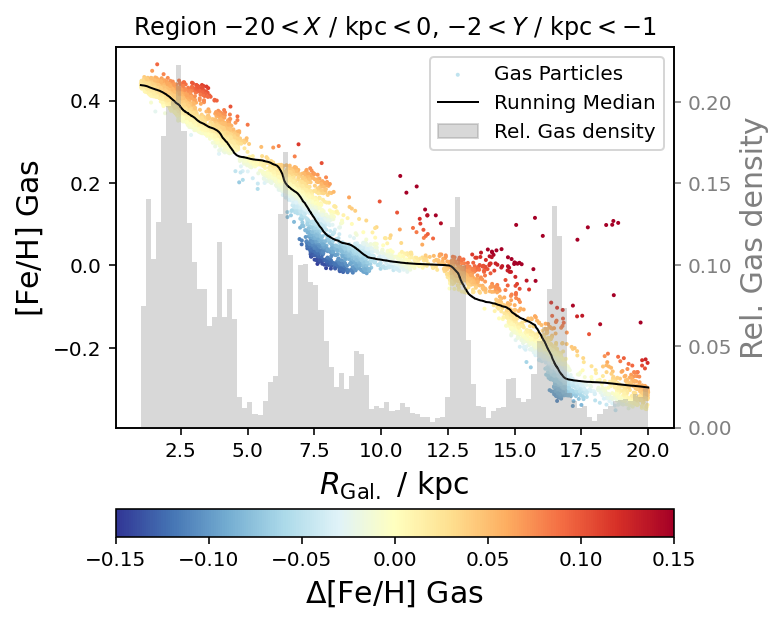

In [63]:
selection = (
    (sim_gas['R'] < nihao_R_max) &
    (sim_gas['x'] < 0) &
    (sim_gas['y'] > -2) &
    (sim_gas['y'] < -1) &
    (abs(sim_gas['z']) < 4)
)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(5,5))

s = ax.scatter(
    sim_gas['R'][selection],
    sim_gas['Fe_H'][selection],
    c = sim_gas['Fe_H_residuals'][selection],
    cmap='RdYlBu_r', vmin = -0.15, vmax= 0.15,
    s = 1,
    label = r'Gas Particles'
)

sorted_indices = np.argsort(sim_gas['R'][selection])
R_sorted = sim_gas['R'][selection][sorted_indices]
delta_fe_h_sorted = sim_gas['Fe_H'][selection][sorted_indices]

running_median = uniform_filter1d(delta_fe_h_sorted, size=1000, mode='nearest')
ax.plot(R_sorted, running_median, color='k', label='Running Median', linewidth=1)

ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]}$ Gas')

# Create a secondary y-axis for the histogram
ax2 = ax.twinx()
ax2.hist(
    sim_gas['R'][selection],
    bins=100, alpha=0.3, color='gray', label='Histogram of R', density=True
)
ax2.set_ylabel('Rel. Gas density',color='gray')
ax2.tick_params(axis='y', colors='gray')

handles2 = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.3)]  # Create a custom patch for the histogram
labels2 = ['Rel. Gas density']
handles1, labels1 = ax.get_legend_handles_labels()
ax.legend(handles=handles1 + handles2, labels=labels1 + labels2, fontsize=10)

ax.set_title(r'Region $-20 < X~/~\mathrm{kpc} < 0$, $-2 < Y~/~\mathrm{kpc} < -1$')
cbar = plt.colorbar(s, ax=ax, label=r'$\Delta\mathrm{[Fe/H]}$ Gas', orientation='horizontal')
plt.savefig('figures/region_r_feh_gas_density.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

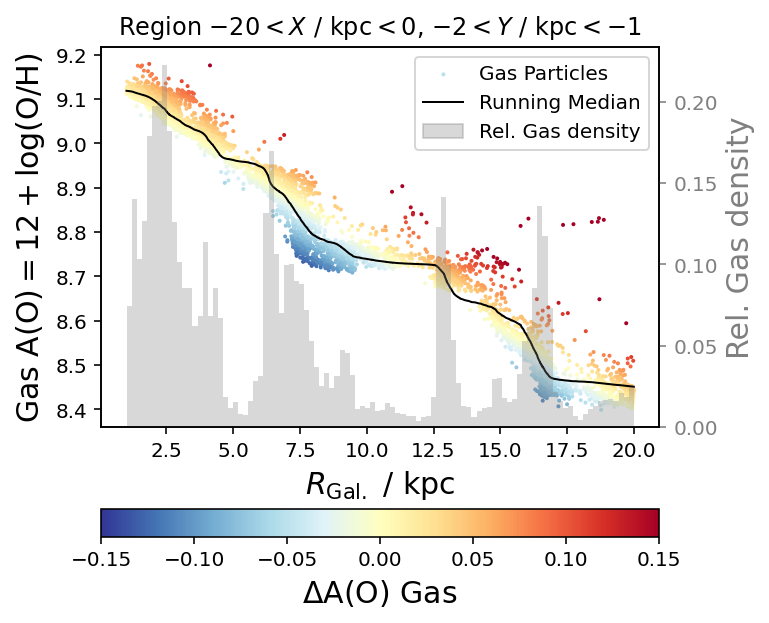

In [62]:
selection = (
    (sim_gas['R'] < nihao_R_max) &
    (sim_gas['x'] < 0) &
    (sim_gas['y'] > -2) &
    (sim_gas['y'] < -1) &
    (abs(sim_gas['z']) < 4)
)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(5,5))

s = ax.scatter(
    sim_gas['R'][selection],
    sim_gas['A_O'][selection],
    c = sim_gas['A_O_residuals'][selection],
    cmap='RdYlBu_r', vmin = -0.15, vmax= 0.15,
    s = 1,
    label = r'Gas Particles'
)

sorted_indices = np.argsort(sim_gas['R'][selection])
R_sorted = sim_gas['R'][selection][sorted_indices]
delta_fe_h_sorted = sim_gas['A_O'][selection][sorted_indices]

running_median = uniform_filter1d(delta_fe_h_sorted, size=1000, mode='nearest')
ax.plot(R_sorted, running_median, color='k', label='Running Median', linewidth=1)

ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'Gas $\mathrm{A(O)} = 12 + \log (\mathrm{O/H})$')

# Create a secondary y-axis for the histogram
ax2 = ax.twinx()
ax2.hist(
    sim_gas['R'][selection],
    bins=100, alpha=0.3, color='gray', label='Histogram of R', density=True
)
ax2.set_ylabel('Rel. Gas density',color='gray')
ax2.tick_params(axis='y', colors='gray')

handles2 = [plt.Rectangle((0,0),1,1, color='gray', alpha=0.3)]  # Create a custom patch for the histogram
labels2 = ['Rel. Gas density']
handles1, labels1 = ax.get_legend_handles_labels()
ax.legend(handles=handles1 + handles2, labels=labels1 + labels2, fontsize=10)

ax.set_title(r'Region $-20 < X~/~\mathrm{kpc} < 0$, $-2 < Y~/~\mathrm{kpc} < -1$')
cbar = plt.colorbar(s, ax=ax, label=r'$\Delta\mathrm{A(O)}$ Gas', orientation='horizontal')
plt.savefig('figures/region_r_ao_gas_density.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
sharey = True

f, gs = plt.subplots(1,4,figsize = (12,4), sharex=True,sharey=sharey)

x_range = -5.5-8,5.5-8
y_range = -5.5,5.5

gas_within_x_radius = (
    (abs(sim_gas['x'] - chosen_position[0]) < radius) &
    (abs(sim_gas['y'] - chosen_position[1]) < radius) &
    (np.sqrt((sim_gas['x']-chosen_position[0])**2 + (sim_gas['y']-chosen_position[1])**2) < radius)
)

R_gas   = sim_gas['R'][gas_in_range].reshape(-1, 1)  # Reshape for sklearn
O_H_gas = sim_gas['O_H'][gas_in_range] + 8.69

radial_gas_model_o_h = LinearRegression()
radial_gas_model_o_h.fit(R_gas, O_H_gas)

# Create a 2D histogram for the gas density plot
H2, xedges2, yedges2 = np.histogram2d(
    sim_gas['x'][gas_within_x_radius], 
    sim_gas['y'][gas_within_x_radius], 
    bins=50, 
    range=[x_range, y_range]
)
xcenters2 = (xedges2[:-1] + xedges2[1:]) / 2
ycenters2 = (yedges2[:-1] + yedges2[1:]) / 2

ax = gs[0]
ax.text(0.04,0.95,panels[0]+' Simulation (Young Stars)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(x_range)
ax.set_xticks([-12,-10,-8,-6,-4])
ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylim(y_range)

within_x_radius = (
    (np.sqrt((sim_stars['x']-chosen_position[0])**2 + (sim_stars['y']-chosen_position[1])**2) < radius) &
    (sim_stars['age'] < age_cut)
)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['x'][within_x_radius], 
    sim_stars['y'][within_x_radius],
    sim_stars['O_H'][within_x_radius] + 8.69, statistic='median',
    bins = 50
)

pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu_r')#, vmin=-0.175, vmax=0.025)
plt.colorbar(pcm, ax=ax, label='[Fe/H] (Stars $<'+str(nihao_age_max)+'\,\mathrm{Gyr}$)',orientation='horizontal')

# Add contour lines and legend
ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='w', linewidths = 3)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='k', linewidths = 1)
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Gas Overdensity')
ax.legend(handles=[contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1, framealpha=0.85)

ax = gs[1]
ax.text(0.04,0.95,panels[1]+' Simulation (Young Stars)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(x_range)
ax.set_xticks([-12,-10,-8,-6,-4])
if not sharey:
    ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylim(y_range)

within_x_radius = (
    (np.sqrt((sim_stars['x']-chosen_position[0])**2 + (sim_stars['y']-chosen_position[1])**2) < radius) &
    (sim_stars['age'] < age_cut)
)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['x'][within_x_radius], 
    sim_stars['y'][within_x_radius],
    sim_stars['Fe_H_residuals'][within_x_radius], statistic='median',
    bins = 50
)

pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu_r', vmin=-0.1, vmax=0.1)
plt.colorbar(pcm, ax=ax, label=r'$\Delta\mathrm{[Fe/H]}$ (Stars $<'+str(nihao_age_max)+'\,\mathrm{Gyr}$)',orientation='horizontal')

# Add contour lines and legend
ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='w', linewidths = 3)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='k', linewidths = 1)
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Gas Overdensity')
ax.legend(handles=[contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1, framealpha=0.85)

ax = gs[2]
ax.text(0.04,0.95,panels[2]+' Simulation (Gas)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(x_range)
ax.set_xticks([-12,-10,-8,-6,-4])
if not sharey:
    ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylim(y_range)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_gas['x'][gas_within_x_radius], 
    sim_gas['y'][gas_within_x_radius],
    sim_gas['O_H'][gas_within_x_radius] + 8.69, statistic='median',
    bins = 50
)

pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu_r', vmin = -0.12 +  8.69, vmax = 0.35 +  8.69)
plt.colorbar(pcm, ax=ax, label='A(O) Gas',orientation='horizontal')

# Add contour lines and legend
ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='w', linewidths = 3)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='k', linewidths = 1)
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Gas Overdensity')
ax.legend(handles=[contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1, framealpha=0.85)

ax = gs[3]
ax.text(0.04,0.95,panels[3]+' Simulation (Gas)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$X_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_xlim(x_range)
ax.set_xticks([-12,-10,-8,-6,-4])
if not sharey:
    ax.set_ylabel(r'$Y_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylim(y_range)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_gas['x'][gas_within_x_radius], 
    sim_gas['y'][gas_within_x_radius],
    sim_gas['O_H'][gas_within_x_radius] + 8.69 - radial_gas_model_o_h.predict(sim_gas['R'][gas_within_x_radius].reshape(-1,1)), statistic='median',
    bins = 50
)

pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu_r', vmin = -0.15, vmax= 0.15)
plt.colorbar(pcm, ax=ax, label=r'$\Delta\mathrm{A(O)}$ Gas',orientation='horizontal')

# Add contour lines and legend
ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='w', linewidths = 3)
s2 = ax.contour(xcenters2, ycenters2, H2.T, levels=(20,), colors='k', linewidths = 1)
contour_handle = plt.Line2D([0], [0], color='k', lw=2, label=r'Gas Overdensity')
ax.legend(handles=[contour_handle],ncol=2, fontsize=8,loc='lower left',handlelength=1,columnspacing=1, framealpha=0.85)


plt.tight_layout(w_pad=-3)
plt.savefig('figures/nihao_gas_stars_density_overlay_ao.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
f, gs = plt.subplots(2,1,figsize=(6,4.5),sharex=True)

slope = 1.09
intercept = - 0.037

ax = gs[0]
ax.text(0.025,0.935,panels[0],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
h = ax.hist2d(
    sim_gas['O_H'][gas_in_range] + 8.69,
    sim_gas['O_H'][gas_in_range] - sim_gas['Fe_H'][gas_in_range],
    cmin = 1, cmap='RdPu_r',
    bins = (100,np.linspace(-0.06,0.11,100)),
    norm = LogNorm()
);
plt.colorbar(h[-1],ax=ax,label='Gas Particles')
# ax.set_xlabel('A(O) = 12 + log(O/H)')
ax.set_ylabel('Gas \n '+r'$\mathrm{[O/H]} - \mathrm{[Fe/H]}$')
ax.text(0.02,0.05,r'$\mathrm{[O/H]} = \mathrm{A(O)} - \mathrm{A(O)_\odot}$ with $\mathrm{A(O)_\odot} = 8.69$', transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.95),va='bottom',ha='left')

ax = gs[1]
ax.text(0.025,0.935,panels[1],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
h = ax.hist2d(
    sim_gas['O_H'][gas_in_range] + 8.69,
    (slope * (sim_gas['O_H'][gas_in_range]) + intercept) - sim_gas['Fe_H'][gas_in_range],
    cmin = 1, cmap='RdPu_r',
    bins = (100,np.linspace(-0.025,0.025,100)),
    norm = LogNorm()
);
plt.colorbar(h[-1],ax=ax,label='Gas Particles')
ax.set_xlabel('Gas A(O) = 12 + log(O/H)')
ax.set_ylabel('Gas \n '+r'$\mathrm{[Fe/H]} - \mathrm{[O/H]}^\prime$')
ax.text(0.02,0.05,r'$\mathrm{[O/H]}^\prime = '+str(slope)+' \cdot \mathrm{[O/H]}'+str(intercept)+'$', transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.95),va='bottom',ha='left')

plt.tight_layout()
plt.savefig('figures/fe_h_vs_a_o_gas.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
f, axes = plt.subplots(3,1,figsize=(6,6.5),sharex=True)

axes = axes.flatten()

ax = axes[0]
ax.text(0.025,0.65,panels[0],fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

ax.hist2d(
    sim_gas['R'][gas_in_range],
    sim_gas['Fe_H'][gas_in_range],
    cmin = 1, cmap = 'plasma',
    norm = LogNorm(),
    bins = (np.linspace(0,nihao_R_max,100),np.linspace(-0.75,0.55,100)),
    zorder = 1
)

R_line = np.linspace(0,nihao_R_max,100)
Fe_H_line = model_gas_global.predict(R_line.reshape(-1, 1))

ax.plot(
    R_line,
    Fe_H_line,
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    Fe_H_line,
    c = 'r',lw=2,ls='dashed',
    zorder = 2, label = 'Global Fit (all particles):\n'+r'$f(R_\mathrm{Gal.}) = '+"{:.4f}".format(model_gas_global.intercept_)+' '+"{:.4f}".format(model_gas_global.coef_[0])+'\cdot R_\mathrm{Gal.}$'
)

ax.legend(loc='lower left', fontsize=10, handlelength=1)
ax.set_xlim(0,nihao_R_max)
# ax.set_xticks([2,5,8,11,14,17,20])

R_e_ticks = np.arange(0,nihao_R_max,nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

ax = axes[1]
ax.text(0.025,0.94,panels[1],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]} - f(R_\mathrm{Gal.})$')

gas_prediction = model_gas_global.predict(sim_gas['R'][gas_in_range].reshape(-1,1))

ax.hist2d(
    sim_gas['R'][gas_in_range],
    sim_gas['Fe_H'][gas_in_range] - gas_prediction,
    cmin = 1, cmap = 'plasma',
    norm = LogNorm(),
    bins = (np.linspace(0,nihao_R_max,100),np.linspace(-0.5,0.5,100)),
    zorder = 1
)

ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'r',lw=2,ls='dashed',
    zorder = 2
)

# ax.legend(loc='upper right', fontsize=10, handlelength=1, framealpha=0.9)


# ax.set_xlim(0,nihao_R_max)
# ax.set_xticks([2,5,8,11,14,17,20])

ax = axes[2]
ax.text(0.025,0.94,panels[2],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$\mathrm{[Fe/H]} - f(R_\mathrm{Gal.})$')

R_bins = np.linspace(0,nihao_R_max,41)

Fe_H_spread = []

for R_index, (R_bin_min, R_bin_max) in enumerate(zip(R_bins[:-1],R_bins[1:])):

    in_R = (
        (sim_gas['R'][gas_in_range] > R_bin_min) &
        (sim_gas['R'][gas_in_range] <= R_bin_max)
    )

    perc = np.percentile((sim_gas['Fe_H'][gas_in_range] - gas_prediction)[in_R],q=[16,50,84])

    if R_bin_min in [0.0,8.0,19.0]:
        Fe_H_spread = np.round(0.5*(perc[2]-perc[0]),2)
        np.savetxt('tex_text/fe_h_spread_at_R_'+str(int(R_bin_min))+'kpc_gas.tex',[r'$\sigma \mathrm{[Fe/H]} = '+str(Fe_H_spread)+'\,\mathrm{dex}$%'],fmt='%s')
        
    if R_index == 0:
        label = r'$\mathrm{Median}\pm 1 \sigma$'
    else:
        label = '_nolegend_'

    s = ax.errorbar(
        0.5*(R_bin_min+R_bin_max),
        perc[1],
        yerr = [[perc[1]-perc[0]],[perc[2]-perc[1]]],
        c = 'k',ms=5,fmt='o',label = label,
        capsize=2, zorder = 1
    )
            
    if R_index == 0:
        legend_labels = []
        legend_labels.append(s)

ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'w',lw=2,
    zorder = 2
)
s2 = ax.plot(
    R_line,
    np.zeros(len(R_line)),
    c = 'r',lw=2,ls='dashed',
    zorder = 2
)

ax.set_ylim(-0.2,0.2)

ax.set_xlim(0,nihao_R_max)
ax.set_xticks([2,5,8,11,14,17,20])

ax.legend(loc = 'upper center', fontsize=10)

plt.tight_layout(h_pad=0)

plt.savefig('figures/global_r_feh_fit_gas.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
f, axes = plt.subplots(4,1,figsize=(6,8),sharex=True)
axes = axes.flatten()

stars_within_100kpc = (
    (sim_stars['R'] < 100) &
    (abs(sim_stars['z']) < 50)
)
young_stars_within_100kpc = (
    (sim_stars['R'] < 100) &
    (sim_stars['age'] < nihao_age_max) &
    (abs(sim_stars['z']) < 50)
)

gas_within_100kpc = (
    (sim_gas['R'] < 100) &
    (abs(sim_gas['z']) < 50)
)

fe_h_p0 = np.percentile(sim_stars['Fe_H'][young_stars_within_100kpc],q=0)
a_o_p0 = np.percentile(sim_stars['O_H'][young_stars_within_100kpc]+ 8.69,q=0)

fe_h_bins = np.linspace(-2.5,0.65,100)

ax = axes[0]
ax.text(0.975,0.91,panels[0]+' All Stars',fontsize=15,transform=ax.transAxes,va='top',ha='right',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

ax.hist2d(
    sim_stars['R'][stars_within_100kpc],
    sim_stars['Fe_H'][stars_within_100kpc],
    cmin = 1, cmap = 'cividis',
    norm = LogNorm(),
    bins = (np.linspace(0,100,100),fe_h_bins),
    zorder = 1
)
ax.plot([0,20],[fe_h_p0,fe_h_p0],c = 'k', lw=4, label = 'Young stars min([Fe/H]) = '+str(np.round(fe_h_p0,2)))
ax.plot([0,20],[fe_h_p0,fe_h_p0],c = 'w', lw=2, ls='dashed')

R_e_ticks = np.arange(0,100,5*nihao_R_e)
ax2 = ax.twiny()
ax2.set_xticks(R_e_ticks)
ax2.set_xticklabels(5*np.arange(len(R_e_ticks)))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{R_e}$')

ax = axes[1]
ax.text(0.025,0.05,panels[1]+' Age $<'+str(nihao_age_max)+'\,\mathrm{Gyr}$',fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

ax.hist2d(
    sim_stars['R'][young_stars_within_100kpc],
    sim_stars['Fe_H'][young_stars_within_100kpc],
    cmin = 1, cmap = 'cividis',
    norm = LogNorm(),
    bins = (np.linspace(0,100,100),fe_h_bins),
    zorder = 1
)
ax.plot([0,20],[fe_h_p0,fe_h_p0],c = 'k', lw=4, label = 'Young stars min([Fe/H]) = '+str(np.round(fe_h_p0,2)))
ax.plot([0,20],[fe_h_p0,fe_h_p0],c = 'w', lw=2, ls='dashed')
ax.legend(fontsize=10, loc='upper right')

ax = axes[2]
ax.text(0.025,0.05,panels[2]+' Gas',fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

ax.hist2d(
    sim_gas['R'][gas_within_100kpc],
    sim_gas['Fe_H'][gas_within_100kpc],
    cmin = 1, cmap = 'plasma',
    norm = LogNorm(),
    bins = (np.linspace(0,100,100),fe_h_bins),
    zorder = 1
)
ax.plot([0,20],[fe_h_p0,fe_h_p0],c = 'k', lw=4, label = 'Young stars min([Fe/H]) = '+str(np.round(fe_h_p0,2)))
ax.plot([0,20],[fe_h_p0,fe_h_p0],c = 'w', lw=2, ls='dashed')

ax = axes[3]
ax.text(0.025,0.05,panels[3]+' Gas',fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_ylabel(r'$\mathrm{A(O)} \equiv$'+'\n'+r'$12 + \log(\mathrm{O/H})$')

ax.hist2d(
    sim_gas['R'][gas_within_100kpc],
    sim_gas['O_H'][gas_within_100kpc] + 8.69,
    cmin = 1, cmap = 'plasma',
    norm = LogNorm(),
    bins = (np.linspace(0,100,100),np.linspace(6.85,9.35,100)),
    zorder = 1
)
ax.plot([0,20],[a_o_p0,a_o_p0],c = 'k', lw=4, label = 'Young stars min(A(O)) = '+str(np.round(a_o_p0,2)))
ax.plot([0,20],[a_o_p0,a_o_p0],c = 'w', lw=2, ls='dashed')
ax.legend(fontsize=10, loc='upper right')

ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')

plt.tight_layout(h_pad=0)

plt.savefig('figures/trace_stars_and_gas_100kpc.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Fit a linear regression model
R   = sim_gas['R'][gas_in_range].reshape(-1, 1)  # Reshape for sklearn
Fe_H = sim_gas['Fe_H'][gas_in_range]

model_gas_global = LinearRegression()
model_gas_global.fit(R, Fe_H)
print('Gas: ',model_gas_global.intercept_,model_gas_global.coef_[0])

R_line = np.linspace(0,nihao_R_max,100)

f, ax = plt.subplots()
ax.plot(
    R_line,
    model_gas_global.predict(R_line.reshape(-1,1)),
    label = 'Gas'
)

ages = np.arange(0,7+1)

for age_index, (age_min, age_max) in enumerate(zip(ages[:-1],ages[1:])):

    # Let's fit a linear model to all data points
    in_age_range = (
            (sim_stars['R'] < nihao_R_max) &
            (sim_stars['age'] >= age_min) & 
            (sim_stars['age'] < age_max) & 
            np.isfinite(sim_stars['z'])
    )

    # Fit a linear regression model
    R    = sim_stars['R'][in_age_range].reshape(-1, 1)  # Reshape for sklearn
    Fe_H = sim_stars['Fe_H'][in_age_range]

    model_global_age = LinearRegression()
    model_global_age.fit(R, Fe_H)
    
    ax.plot(
        R_line,
        model_global_age.predict(R_line.reshape(-1,1)),
        label = str(age_min)+'-'+str(age_max),
        ls = 'dashed'
    )

    print('Stars: '+str(age_min)+'-'+str(age_max),model_global_age.intercept_,model_global_age.coef_[0])

ax.legend(ncol=2)

# Reference parameters: bar strength and length, bulge/total mass ratio B/T, spin parameter lambda_r

In [ ]:
# What about the bar?

# Compute the m=2 Fourier component
A2 = np.sum(sim_stars['mass'][in_range] * np.exp(2j * sim_stars['phi'][in_range])) / np.sum(sim_stars['mass'][in_range])

# Bar strength is the magnitude of A2
bar_strength = np.abs(A2)
print('bar_strength', bar_strength)

A2_R = []
radii = np.linspace(0, 20, 100)  # You can adjust the range and number of bins

for r in radii[2:]:
    in_r_radius = (sim_stars['R'] < r) & in_range
    A2 = np.sum(sim_stars['mass'][in_r_radius] * np.exp(2j * sim_stars['phi'][in_r_radius])) / np.sum(sim_stars['mass'][in_r_radius])
    A2_R.append(np.abs(A2))

A2_R = np.array(A2_R)

# Find the radius where the A2 drops to half of its maximum value
max_A2 = np.max(A2_R)
bar_radius = radii[np.where(A2_R <= 0.5 * max_A2)[0][0]]
print('bar_radius', bar_radius)

## Comparison with Johnson et al. (2024)

In [ ]:
in_range = (
        (sim_stars['R'] < nihao_R_max) &
        (sim_stars['age'] < 10) &
        (abs(sim_stars['z']) < 2*abs_z_young_within_r_max_99perc)
)

f, gs = plt.subplots(2,1)

ax = gs[0]
# ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')
stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['R'][in_range], 
    sim_stars['z'][in_range],
    sim_stars['Fe_H'][in_range], statistic='median',
    bins=(np.linspace(0,nihao_R_max,100),np.linspace(-2*abs_z_young_within_r_max_99perc,2*abs_z_young_within_r_max_99perc,100))
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu',vmin = -0.5,vmax=0.25)
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label('[Fe/H]')
ax.axhline(0,lw=1,color='k',ls='dashed')

ax = gs[1]
ax.set_xlabel(r'$R_\mathrm{Gal.}~/~\mathrm{kpc}$')
ax.set_ylabel(r'$z_\mathrm{Gal.}~/~\mathrm{kpc}$')

stats, x_edge, y_edge, _ = binned_statistic_2d(
    sim_stars['R'][in_range], 
    sim_stars['z'][in_range],
    sim_stars['age'][in_range], statistic='median',
    bins=(np.linspace(0,nihao_R_max,100),np.linspace(-2*abs_z_young_within_r_max_99perc,2*abs_z_young_within_r_max_99perc,100))
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu',vmin = 0, vmax=10)
ax.axhline(0,lw=1,color='k',ls='dashed')
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label('Age / Gyr')
plt.tight_layout()
plt.savefig('figures/R_z_Fe_h_age.png',dpi=200,bbox_inches='tight',facecolor='w')

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

cmap = get_cmap('cividis')

r_mins = np.arange(3,13.1,2)
r_maxs = np.arange(5,15.1,2)

cmap_norm = Normalize(vmin=0, vmax=len(r_maxs))


f, gs = plt.subplots(2,2,figsize=(8,6))
gs = gs.flatten()

for r_index, (r_min, r_max) in enumerate(zip(r_mins,r_maxs)):

    in_range = (
        (sim_stars['R'] > r_min) &
        (sim_stars['R'] <= r_max) &
        (sim_stars['age'] < 10) &
        (abs(sim_stars['z']) < 0.5)
    )

    ax = gs[0]
    ax.hist(
        sim_stars['age'][in_range],
        bins = np.linspace(0,10,20),
        density=True,
        histtype='step',
        color=cmap(cmap_norm(r_index)),
        label = str(r_min)+'-'+str(r_max)+'kpc'
    )
    
    ax = gs[1]
    ax.hist(
        sim_stars['O_H'][in_range],
        bins = np.linspace(-0.5,0.5,100),
        density=True,
        histtype='step',
        color=cmap(cmap_norm(r_index)),
        label = str(r_min)+'-'+str(r_max)+'kpc'
    )
    
gs[0].legend(ncol=2,fontsize=10,loc='lower center')

for r_index, (r_min, r_max) in enumerate(zip(np.arange(0,14.1,1),np.arange(1,15.1,1))):

    in_range = (
        (sim_stars['R'] > r_min) &
        (sim_stars['R'] <= r_max) &
        (sim_stars['age'] < 10) &
        (abs(sim_stars['z']) < 0.5)
    )
    
    ax = gs[2]
    ax.scatter(
        [0.5*(r_min+r_max)],
        [np.median(sim_stars['age'][in_range])],
        c = 'k',
        marker = '*'
    )
    
    ax = gs[3]
    if r_index == 0:
        label1 = '[O/H]'
        label2 = '[Fe/H]'
        
    else:
        label1 = '_nolegend_'
        label2 = '_nolegend_'

    ax.scatter(
        [0.5*(r_min+r_max)],
        [np.median(sim_stars['O_H'][in_range])],
        c = 'r',
        label = label1,
        marker = '*'
    )
    ax.scatter(
        [0.5*(r_min+r_max)],
        [np.median(sim_stars['Fe_H'][in_range])],
        c = 'b',
        label = label2,
        marker = '*'
    )
gs[3].legend(fontsize=10)
    
gs[2].set_ylim(0,10)
gs[3].set_ylim(-0.7,0.7)

gs[0].set_xlabel('Age / Gyr')
gs[0].set_ylabel('P(Age)')

gs[1].set_xlabel('[O/H]')
gs[1].set_ylabel('P([O/H])')

gs[2].set_xlabel('R / kpc')
gs[2].set_ylabel('Age / Gyr')

gs[3].set_xlabel('R / kpc')
gs[3].set_ylabel('Median [X/H]')

plt.tight_layout()
plt.savefig('figures/johnson2024_fig2.png',dpi=200,bbox_inches='tight',facecolor='w')